In [1]:
import os
import sys
from scgt import GeoTiff
sys.path.append('/Users/nvalett/Documents/Natalie/Species Dist Research/Code/ecoscape-earth/')
sys.path.append('/Users/nvalett/Documents/Natalie/Species Dist Research/Code/ecoscape-earth/ecoscape-connectivity/')
from EcoLinker.EcoLinker.restorationOptimizer import restorationOptimizer, defecitRestoration, lowResDefecitRestoration, noisyDefecitRestoration, utopianRestoration, flowRestoration, lowResFlowRestoration, greedyFlowRestoration, bfsFlowRestoration
# from ecoscape_connectivity_local import repopulation, util
import matplotlib.pyplot as plt
import ecoscape_connectivity
from scgt import GeoTiff, Tile
import numpy as np
import torch
import rasterio

In [2]:
DATA_PATH="/Users/nvalett/Documents/Natalie/Species Dist Research/Thesis/EcoLinker/tests/assets"
HABITAT_PATH = os.path.join(DATA_PATH, "smol/hab_smol.tif")
TERRAIN_PATH = os.path.join(DATA_PATH, "smol/terrain.tif")
RESTORED_TERRAIN_PATH = os.path.join(DATA_PATH, "smol/restored_ter_smol.tif")
PERMEABILITY_PATH = os.path.join(DATA_PATH, "paper_repro/transmission_refined_1.csv")

CONNECTIVITY_PATH = os.path.join(DATA_PATH, "smol/repop.tif")
RESTORED_CONNECTIVITY_PATH = os.path.join(DATA_PATH, "smol/repop_after_restoration.tif")
FLOW_PATH = os.path.join(DATA_PATH, "smol/grad.tif")
DEATH_PATH = os.path.join(DATA_PATH, "smol/death.tif")
RESTORED_FLOW_PATH = os.path.join(DATA_PATH, "smol/grad_after_restoration.tif")
LOW_RES_FLOW_PATH = os.path.join(DATA_PATH, "smol/flow_low_res.tif")

UTOPIAN_CONNECTIVITY_PATH = os.path.join(DATA_PATH, "smol/repop_utopian.tif")
UTOPIAN_FLOW_PATH = os.path.join(DATA_PATH, "smol/grad_utopian.tif")

unrestorable = [104,500, 501, 502, 503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,900, 901, 902, 903, 904, 905, 906,907,980,981,982,983,984,985,986,909,910,1000,1001,1002,1003,1004,1100,1101,1111,1112,1102,1103,1104,1105,1106,1200,1201,1202,1203,1204,1205,1206,1207,1300,1301,1302,1303,1304,1305,    1402]

with GeoTiff.from_file(HABITAT_PATH) as hab:
    hab_mat = hab.get_all_as_tile().m.squeeze(0)

flowOptimizer = flowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, PERMEABILITY_PATH, 50, hab_mat, unrestorable)
lowResFlowOptimizer = lowResFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, LOW_RES_FLOW_PATH, PERMEABILITY_PATH, 2, 2, hab_mat, unrestorable, 50)
greedyFlowOptimizer = greedyFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, PERMEABILITY_PATH, 50, hab_mat, unrestorable, corridor_hop=2)
bfsFlowOptimizer = bfsFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, PERMEABILITY_PATH, 50, hab_mat, unrestorable, num_corridors=10, corridor_hop=2, metric='flow')

# n comparison

In [3]:
approaches = ['flow_approach', 'bfs_flow_approach', 'greedy_flow_approach', 'low_res_flow_approach', 'death_approach', 'utopian_approach']
conn_px_results_list = {approach: [] for approach in approaches}
conn_px_results_list_per_det = {}

determinism_seeds = [100]
n_range = [i*10 for i in range(1,11)]

In [6]:
# BFS
conn_px_results_list = {approach: [] for approach in approaches}
print(f'bfsFlowOptimizer')
for n in n_range:
    bfsFlowOptimizer = bfsFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, PERMEABILITY_PATH, n, hab_mat, unrestorable, num_corridors=10, corridor_hop=2, metric='flow')

    bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
    permiability_restored = bfsFlowOptimizer.restore()
    bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
    # print(f"Delta connectivity: {bfsFlowOptimizer.get_delta_connectivity()}")
    # print(f"Permiability Restored: {permiability_restored}")
    # print(f"Connectivity/permiability_restored: {round(bfsFlowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
    # print(f"Connectivity/pixels restored: {round(bfsFlowOptimizer.get_delta_connectivity()/bfsFlowOptimizer.pixels, 2)}")
    conn_px_results_list["bfs_flow_approach"].append(round(bfsFlowOptimizer.get_delta_connectivity(), 2))

    TERRAIN_CHANGED = os.path.join(DATA_PATH, f"smol/changed_terrain_bfs_n{n}.tif")
    CONNECTIVITY_DIFF = os.path.join(DATA_PATH, f"smol/connectivity_diff_bfs_n{n}.tif")

    bfsFlowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED, value=1)
    bfsFlowOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF)

# DFS
print(f'greedyFlowOptimizer')
for n in n_range:    
    greedyFlowOptimizer = greedyFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, PERMEABILITY_PATH, n, hab_mat, unrestorable, corridor_hop=2)

    greedyFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
    permiability_restored = greedyFlowOptimizer.restore()
    greedyFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
    # print(f"Delta connectivity: {greedyFlowOptimizer.get_delta_connectivity()}")
    # print(f"Permiability Restored: {permiability_restored}")
    # print(f"Connectivity/permiability_restored: {round(greedyFlowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
    # print(f"Connectivity/pixels restored: {round(greedyFlowOptimizer.get_delta_connectivity()/greedyFlowOptimizer.pixels, 2)}")
    conn_px_results_list["greedy_flow_approach"].append(round(greedyFlowOptimizer.get_delta_connectivity(), 2))

    TERRAIN_CHANGED = os.path.join(DATA_PATH, f"smol/changed_terrain_dfs_n{n}.tif")
    CONNECTIVITY_DIFF = os.path.join(DATA_PATH, f"smol/connectivity_diff_dfs_n{n}.tif")

    greedyFlowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED, value=1)
    greedyFlowOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF)

# FLOW
print(f'flowOptimizer')
for n in n_range:
    flowOptimizer = flowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, PERMEABILITY_PATH, n)

    flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
    permiability_restored = flowOptimizer.restore()
    flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
    # print(f"Delta connectivity: {flowOptimizer.get_delta_connectivity()}")
    # print(f"Permiability Restored: {permiability_restored}")
    # print(f"Connectivity/permiability_restored: {round(flowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
    # print(f"Connectivity/pixels restored: {round(flowOptimizer.get_delta_connectivity()/flowOptimizer.pixels, 2)}")
    conn_px_results_list["flow_approach"].append(round(flowOptimizer.get_delta_connectivity(), 2))

    TERRAIN_CHANGED = os.path.join(DATA_PATH, f"smol/changed_terrain_flow_n{n}.tif")
    CONNECTIVITY_DIFF = os.path.join(DATA_PATH, f"smol/connectivity_diff_flow_n{n}.tif")

    flowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED, value=1)
    flowOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF)

# LOW RES FLOW
print(f'lowResFlowOptimizer')
for n in n_range:
    lowResFlowOptimizer = lowResFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, LOW_RES_FLOW_PATH, PERMEABILITY_PATH, 2, 2, n, percent_impermiable=0.75)

    lowResFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
    permiability_restored = lowResFlowOptimizer.restore()
    lowResFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
    # print(f"Delta connectivity: {lowResFlowOptimizer.get_delta_connectivity()}")
    # print(f"Permiability Restored: {permiability_restored}")
    # print(f"Connectivity/permiability_restored: {round(lowResFlowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
    # print(f"Connectivity/pixels restored: {round(lowResFlowOptimizer.get_delta_connectivity()/lowResFlowOptimizer.pixels, 2)}")
    conn_px_results_list["low_res_flow_approach"].append(round(lowResFlowOptimizer.get_delta_connectivity(), 2))
    
    TERRAIN_CHANGED = os.path.join(DATA_PATH, f"smol/changed_terrain_low_res_flow_n{n}.tif")
    CONNECTIVITY_DIFF = os.path.join(DATA_PATH, f"smol/connectivity_diff_low_res_flow_n{n}.tif")

    lowResFlowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED, value=1)
    lowResFlowOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF)

# UTOPIAN
print(f'utopianOptimizer')
for n in n_range:
    utopianOptimizer = utopianRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, PERMEABILITY_PATH, n, UTOPIAN_CONNECTIVITY_PATH, UTOPIAN_FLOW_PATH, 0.93, add_flow=0.5)

    utopianOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
    utopianOptimizer.run_utopian_connectivity(gap_crossing=2, num_gaps=40)
    permiability_restored = utopianOptimizer.restore()
    utopianOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
    # print(f"Delta connectivity: {utopianOptimizer.get_delta_connectivity()}")
    # print(f"Permiability Restored: {permiability_restored}")
    # print(f"Connectivity/permiability_restored: {utopianOptimizer.get_delta_connectivity()/permiability_restored}")
    # print(f"Connectivity/pixels: {utopianOptimizer.get_delta_connectivity()/utopianOptimizer.pixels}")
    conn_px_results_list["utopian_approach"].append(round(utopianOptimizer.get_delta_connectivity(), 2))

    TERRAIN_CHANGED = os.path.join(DATA_PATH, f"smol/changed_terrain_utopian_n{n}.tif")
    CONNECTIVITY_DIFF = os.path.join(DATA_PATH, f"smol/connectivity_diff_utopian_n{n}.tif")

    utopianOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED, value=1)
    utopianOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF)

# DEATH
print(f'defecitOptimizer')
for n in n_range:
    defecitOptimizer = defecitRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, n) #, hab_mat, unrestorable)

    defecitOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
    permiability_restored = defecitOptimizer.restore()
    defecitOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
    # print(f"Delta connectivity: {defecitOptimizer.get_delta_connectivity()}")
    # print(f"Permiability Restored: {permiability_restored}")
    # print(f"Connectivity/permiability_restored: {round(defecitOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
    # print(f"Connectivity/pixels restored: {round(defecitOptimizer.get_delta_connectivity()/defecitOptimizer.pixels, 2)}")
    conn_px_results_list["death_approach"].append(round(defecitOptimizer.get_delta_connectivity(), 2))

    TERRAIN_CHANGED = os.path.join(DATA_PATH, f"smol/changed_terrain_death_n{n}.tif")
    CONNECTIVITY_DIFF = os.path.join(DATA_PATH, f"smol/connectivity_diff_death_n{n}.tif")

    defecitOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED, value=1)
    defecitOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF)


import matplotlib.pyplot as plt

# set mpl params
def setup_mpl():
    plt.rcParams['font.family'] = "Helvetica Neue"
    plt.rcParams['font.size'] = 11
    plt.rcParams['figure.figsize'] = (7,6)
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['lines.linewidth'] = 1.5
setup_mpl()

conn_px_results_list_2 = {}
conn_px_results_list_2["Flow Approach"] = conn_px_results_list['flow_approach']
conn_px_results_list_2["BFS Approach"] = conn_px_results_list['bfs_flow_approach']
conn_px_results_list_2["DFS Approach"] = conn_px_results_list['greedy_flow_approach']
conn_px_results_list_2["Low Res Approach"] = conn_px_results_list['low_res_flow_approach']
conn_px_results_list_2["Deficit Approach"] = conn_px_results_list['death_approach']
conn_px_results_list_2["Utopian Approach"] = conn_px_results_list['utopian_approach']

# Plotting
for approach, results in conn_px_results_list_2.items():
    plt.plot(n_range, results, label=approach)

# Add labels and title
plt.xlabel('Pixels Restored')
plt.ylabel('Delta Connectivity')
plt.title(f'Delta Connectivity per n px restored')
plt.legend()
plt.show()

print(conn_px_results_list_per_det)


bfsFlowOptimizer


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

bfsFlowOptimizer


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

deterministic seed 1:
{'Flow Approach': [30239, 46426, 59900, 68333], 'BFS Approach': [25932, 41597, 49487, 56748], 'DFS Approach': [26768, 42602, 58752, 66819], 'Low Res Approach': [12168, 23131, 30280, 35264], 'Deficit Approach': [1198, 25603, 42706, 57774], 'Utopian Approach': [27493, 41194, 52187, 57788]}


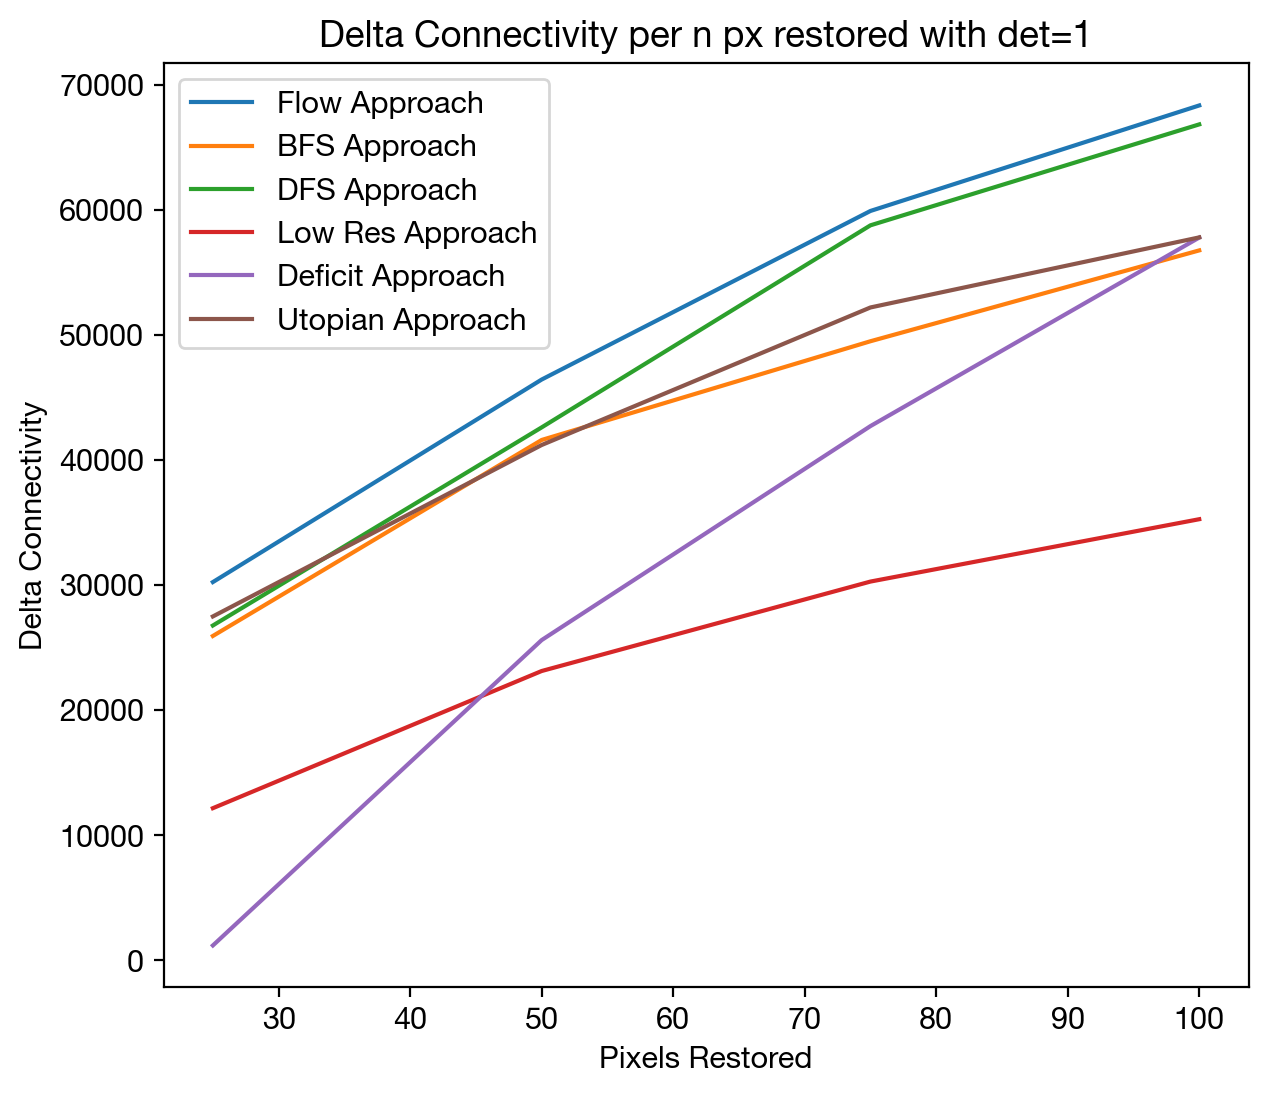

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

deterministic seed 4:
{'Flow Approach': [30239, 46426, 59900, 68333, 29138, 45077, 54905, 65270], 'BFS Approach': [25932, 41597, 49487, 56748, 27074, 39062, 49853, 56821], 'DFS Approach': [26768, 42602, 58752, 66819, 25736, 43428, 50826, 61403], 'Low Res Approach': [12168, 23131, 30280, 35264, 11094, 19232, 28750, 33654], 'Deficit Approach': [1198, 25603, 42706, 57774, 1366, 19863, 33458, 50196], 'Utopian Approach': [27493, 41194, 52187, 57788, 26324, 40620, 49584, 56182]}


ValueError: x and y must have same first dimension, but have shapes (4,) and (8,)

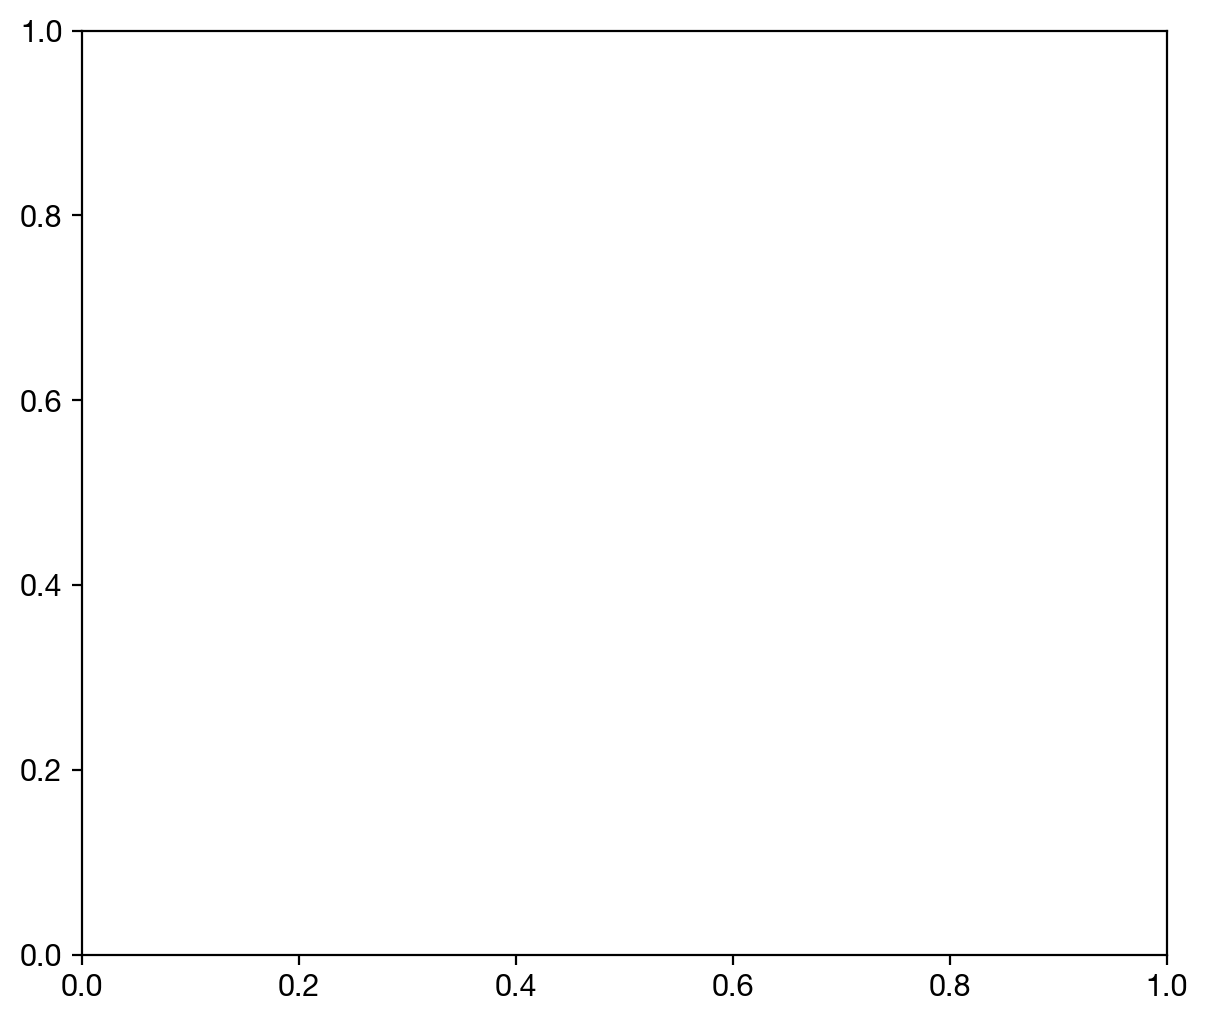

In [15]:
# BFS
conn_px_results_list_per_det = {}
for det in determinism_seeds:
    conn_px_results_list = {approach: [] for approach in approaches}
    for n in n_range:
        # print(f'n: {n}')
        bfsFlowOptimizer = bfsFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, PERMEABILITY_PATH, n, hab_mat, unrestorable, num_corridors=10, corridor_hop=2, metric='flow')

        bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, deterministic=det)
        permiability_restored = bfsFlowOptimizer.restore()
        bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True, deterministic=det)
        # print(f"Delta connectivity: {bfsFlowOptimizer.get_delta_connectivity()}")
        # print(f"Permiability Restored: {permiability_restored}")
        # print(f"Connectivity/permiability_restored: {round(bfsFlowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
        # print(f"Connectivity/pixels restored: {round(bfsFlowOptimizer.get_delta_connectivity()/bfsFlowOptimizer.pixels, 2)}")
        conn_px_results_list["bfs_flow_approach"].append(round(bfsFlowOptimizer.get_delta_connectivity(), 2))

        TERRAIN_CHANGED = os.path.join(DATA_PATH, f"smol/changed_terrain_bfs_det{det}.tif")
        CONNECTIVITY_DIFF = os.path.join(DATA_PATH, f"smol/connectivity_diff_bfs_det{det}.tif")

        bfsFlowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED, value=1)
        bfsFlowOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF)

    # DFS
    for n in n_range:    
        # print(f'n: {n}')
        greedyFlowOptimizer = greedyFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, PERMEABILITY_PATH, n, hab_mat, unrestorable, corridor_hop=2)

        greedyFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, deterministic=det)
        permiability_restored = greedyFlowOptimizer.restore()
        greedyFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True, deterministic=det)
        # print(f"Delta connectivity: {greedyFlowOptimizer.get_delta_connectivity()}")
        # print(f"Permiability Restored: {permiability_restored}")
        # print(f"Connectivity/permiability_restored: {round(greedyFlowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
        # print(f"Connectivity/pixels restored: {round(greedyFlowOptimizer.get_delta_connectivity()/greedyFlowOptimizer.pixels, 2)}")
        conn_px_results_list["greedy_flow_approach"].append(round(greedyFlowOptimizer.get_delta_connectivity(), 2))

        TERRAIN_CHANGED = os.path.join(DATA_PATH, f"smol/changed_terrain_dfs_det{det}.tif")
        CONNECTIVITY_DIFF = os.path.join(DATA_PATH, f"smol/connectivity_diff_dfs_det{det}.tif")

        greedyFlowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED, value=1)
        greedyFlowOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF)

    # FLOW
    for n in n_range:
        # print(f'n: {n}')
        flowOptimizer = flowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, PERMEABILITY_PATH, n)

        flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, deterministic=det)
        permiability_restored = flowOptimizer.restore()
        flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True, deterministic=det)
        # print(f"Delta connectivity: {flowOptimizer.get_delta_connectivity()}")
        # print(f"Permiability Restored: {permiability_restored}")
        # print(f"Connectivity/permiability_restored: {round(flowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
        # print(f"Connectivity/pixels restored: {round(flowOptimizer.get_delta_connectivity()/flowOptimizer.pixels, 2)}")
        conn_px_results_list["flow_approach"].append(round(flowOptimizer.get_delta_connectivity(), 2))

        TERRAIN_CHANGED = os.path.join(DATA_PATH, f"smol/changed_terrain_flow_det{det}.tif")
        CONNECTIVITY_DIFF = os.path.join(DATA_PATH, f"smol/connectivity_diff_flow_det{det}.tif")

        flowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED, value=1)
        flowOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF)

    # LOW RES FLOW
    # for n in n_range:
    for n in n_range:
        # print(f'n: {n}')
        lowResFlowOptimizer = lowResFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, LOW_RES_FLOW_PATH, PERMEABILITY_PATH, 2, 2, n, percent_impermiable=0.75)

        lowResFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, deterministic=det)
        permiability_restored = lowResFlowOptimizer.restore()
        lowResFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True, deterministic=det)
        # print(f"Delta connectivity: {lowResFlowOptimizer.get_delta_connectivity()}")
        # print(f"Permiability Restored: {permiability_restored}")
        # print(f"Connectivity/permiability_restored: {round(lowResFlowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
        # print(f"Connectivity/pixels restored: {round(lowResFlowOptimizer.get_delta_connectivity()/lowResFlowOptimizer.pixels, 2)}")
        conn_px_results_list["low_res_flow_approach"].append(round(lowResFlowOptimizer.get_delta_connectivity(), 2))
        
        TERRAIN_CHANGED = os.path.join(DATA_PATH, f"smol/changed_terrain_low_res_flow_det{det}.tif")
        CONNECTIVITY_DIFF = os.path.join(DATA_PATH, f"smol/connectivity_diff_low_res_flow_det{det}.tif")

        lowResFlowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED, value=1)
        lowResFlowOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF)

    # UTOPIAN
    for n in n_range:
        # print(f'n: {n}')

        utopianOptimizer = utopianRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, PERMEABILITY_PATH, n, UTOPIAN_CONNECTIVITY_PATH, UTOPIAN_FLOW_PATH, 0.95)

        utopianOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, deterministic=det)
        utopianOptimizer.run_utopian_connectivity(deterministic=det)
        permiability_restored = utopianOptimizer.restore()
        utopianOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True, deterministic=det)
        # print(f"Delta connectivity: {utopianOptimizer.get_delta_connectivity()}")
        # print(f"Permiability Restored: {permiability_restored}")
        # print(f"Connectivity/permiability_restored: {utopianOptimizer.get_delta_connectivity()/permiability_restored}")
        # print(f"Connectivity/pixels: {utopianOptimizer.get_delta_connectivity()/utopianOptimizer.pixels}")
        conn_px_results_list["utopian_approach"].append(round(utopianOptimizer.get_delta_connectivity(), 2))

        TERRAIN_CHANGED = os.path.join(DATA_PATH, f"smol/changed_terrain_utopian_det{det}.tif")
        CONNECTIVITY_DIFF = os.path.join(DATA_PATH, f"smol/connectivity_diff_utopian_det{det}.tif")

        utopianOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED, value=1)
        utopianOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF)

    # DEATH
    for n in n_range:
        # print(f'n: {n}')
        defecitOptimizer = defecitRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, n) #, hab_mat, unrestorable)

        defecitOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, deterministic=det)
        permiability_restored = defecitOptimizer.restore()
        defecitOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True, deterministic=det)
        # print(f"Delta connectivity: {defecitOptimizer.get_delta_connectivity()}")
        # print(f"Permiability Restored: {permiability_restored}")
        # print(f"Connectivity/permiability_restored: {round(defecitOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
        # print(f"Connectivity/pixels restored: {round(defecitOptimizer.get_delta_connectivity()/defecitOptimizer.pixels, 2)}")
        conn_px_results_list["death_approach"].append(round(defecitOptimizer.get_delta_connectivity(), 2))

        TERRAIN_CHANGED = os.path.join(DATA_PATH, f"smol/changed_terrain_death_det{det}.tif")
        CONNECTIVITY_DIFF = os.path.join(DATA_PATH, f"smol/connectivity_diff_death_det{det}.tif")

        defecitOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED, value=1)
        defecitOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF)


    import matplotlib.pyplot as plt

    # set mpl params
    def setup_mpl():
        plt.rcParams['font.family'] = "Helvetica Neue"
        plt.rcParams['font.size'] = 11
        plt.rcParams['figure.figsize'] = (7,6)
        plt.rcParams['figure.dpi'] = 200
        plt.rcParams['lines.linewidth'] = 1.5
    setup_mpl()

    conn_px_results_list_2 = {}
    conn_px_results_list_2["Flow Approach"] = conn_px_results_list['flow_approach']
    conn_px_results_list_2["BFS Approach"] = conn_px_results_list['bfs_flow_approach']
    conn_px_results_list_2["DFS Approach"] = conn_px_results_list['greedy_flow_approach']
    conn_px_results_list_2["Low Res Approach"] = conn_px_results_list['low_res_flow_approach']
    conn_px_results_list_2["Deficit Approach"] = conn_px_results_list['death_approach']
    conn_px_results_list_2["Utopian Approach"] = conn_px_results_list['utopian_approach']

    conn_px_results_list_per_det[det] = conn_px_results_list_2

    print(f'deterministic seed {det}:')
    print(conn_px_results_list_2)

    # Plotting
    for approach, results in conn_px_results_list_2.items():
        plt.plot(n_range, results, label=approach)

    # Add labels and title
    plt.xlabel('Pixels Restored')
    plt.ylabel('Delta Connectivity')
    plt.title(f'Delta Connectivity per n px restored with det={det}')
    plt.legend()
    plt.show()

print(conn_px_results_list_per_det)


deterministic seed 4:
{'Flow Approach': [29138, 45077, 54905, 65270], 'BFS Approach': [27074, 39062, 49853, 56821], 'DFS Approach': [25736, 43428, 50826, 61403], 'Low Res Approach': [11094, 19232, 28750, 33654], 'Deficit Approach': [1366, 19863, 33458, 50196], 'Utopian Approach': [26324, 40620, 49584, 56182]}


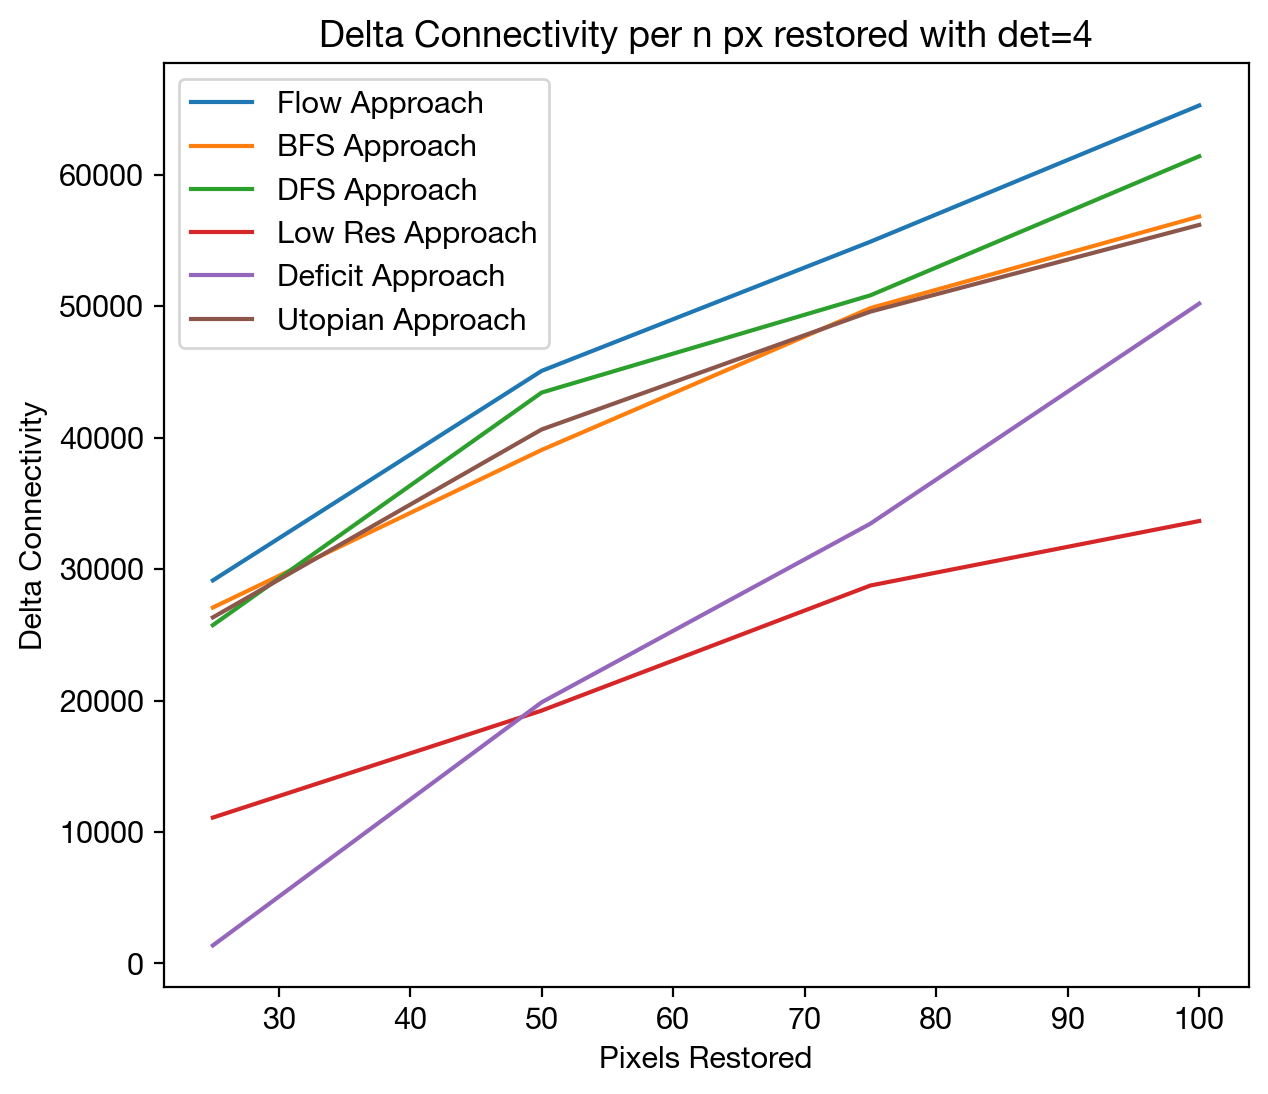

In [21]:
conn_px_results_list_per_det = {}
conn_px_results_list_per_det[det] = conn_px_results_list_2

print(f'deterministic seed {det}:')
print(conn_px_results_list_2)

# Plotting
for approach, results in conn_px_results_list_2.items():
    plt.plot(n_range, results, label=approach)

# Add labels and title
plt.xlabel('Pixels Restored')
plt.ylabel('Delta Connectivity')
plt.title(f'Delta Connectivity per n px restored with det={det}')
plt.legend()
plt.show()

In [9]:
print(conn_px_results_list)

{'flow_approach': [46426, 42732, 47655, 45077, 43673, 45364, 43477, 47973, 44008, 40811], 'bfs_flow_approach': [41597, 39018, 44000, 39062, 41661, 41378, 38039, 43416, 40836, 35531], 'greedy_flow_approach': [42602, 40344, 43777, 43428, 42145, 44622, 43211, 44239, 42969, 39682], 'low_res_flow_approach': [23131, 23390, 19361, 19232, 22431, 24212, 21074, 20872, 21299, 19769], 'death_approach': [25603, 26595, 23234, 19863, 19500, 22946, 15821, 23851, 25695, 17864], 'utopian_approach': [41194, 39956, 39990, 40620, 38697, 43848, 40373, 45420, 45103, 41079]}


In [3]:
approaches = ['flow_approach', 'bfs_flow_approach', 'greedy_flow_approach', 'low_res_flow_approach', 'death_approach', 'utopian_approach']
conn_px_results_list = {approach: [] for approach in approaches}

n_range = [i*10 for i in range(1,11)]

In [4]:
print(n_range)

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [5]:
# BFS
for n in n_range:
    print(f'n: {n}')
    bfsFlowOptimizer = bfsFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, PERMEABILITY_PATH, n, hab_mat, unrestorable, num_corridors=10, corridor_hop=2, metric='flow')

    bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
    permiability_restored = bfsFlowOptimizer.restore()
    bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
    print(f"Delta connectivity: {bfsFlowOptimizer.get_delta_connectivity()}")
    print(f"Permiability Restored: {permiability_restored}")
    print(f"Connectivity/permiability_restored: {round(bfsFlowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
    print(f"Connectivity/pixels restored: {round(bfsFlowOptimizer.get_delta_connectivity()/bfsFlowOptimizer.pixels, 2)}")
    conn_px_results_list["bfs_flow_approach"].append(round(bfsFlowOptimizer.get_delta_connectivity(), 2))

    TERRAIN_CHANGED = os.path.join(DATA_PATH, f"smol/changed_terrain_bfs_n{n}.tif")
    CONNECTIVITY_DIFF = os.path.join(DATA_PATH, f"smol/connectivity_diff_bfs_n{n}.tif")

    bfsFlowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED, value=1)
    bfsFlowOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF)

n: 10


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 19049
Permiability Restored: 0.9999999999999998
Connectivity/permiability_restored: 19049.0
Connectivity/pixels restored: 1904.9


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 20


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 22562
Permiability Restored: 2.0000000000000004
Connectivity/permiability_restored: 11281.0
Connectivity/pixels restored: 1128.1


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 30


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 28966
Permiability Restored: 2.9908613138686144
Connectivity/permiability_restored: 9684.84
Connectivity/pixels restored: 965.53


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 40


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 34439
Permiability Restored: 3.9908613138686153
Connectivity/permiability_restored: 8629.47
Connectivity/pixels restored: 860.98


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 50


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 39018
Permiability Restored: 4.990861313868612
Connectivity/permiability_restored: 7817.89
Connectivity/pixels restored: 780.36


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 60


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 41697
Permiability Restored: 5.990861313868608
Connectivity/permiability_restored: 6960.1
Connectivity/pixels restored: 694.95


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 70


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 45472
Permiability Restored: 6.990861313868605
Connectivity/permiability_restored: 6504.49
Connectivity/pixels restored: 649.6


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 80


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 48560
Permiability Restored: 7.990861313868601
Connectivity/permiability_restored: 6076.94
Connectivity/pixels restored: 607.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 90


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 50844
Permiability Restored: 8.981722627737211
Connectivity/permiability_restored: 5660.83
Connectivity/pixels restored: 564.93


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 100


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 54627
Permiability Restored: 9.981722627737208
Connectivity/permiability_restored: 5472.7
Connectivity/pixels restored: 546.27


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [7]:
print(conn_px_results_list)

{'flow_approach': [], 'bfs_flow_approach': [19049, 22562, 28966, 34439, 39018, 41697, 45472, 48560, 50844, 54627], 'greedy_flow_approach': [], 'low_res_flow_approach': [], 'death_approach': [], 'utopian_approach': []}


In [6]:
# DFS
for n in n_range:
    print(f'n: {n}')
    greedyFlowOptimizer = greedyFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, PERMEABILITY_PATH, n, hab_mat, unrestorable, corridor_hop=2)

    greedyFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
    permiability_restored = greedyFlowOptimizer.restore()
    greedyFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
    print(f"Delta connectivity: {greedyFlowOptimizer.get_delta_connectivity()}")
    print(f"Permiability Restored: {permiability_restored}")
    print(f"Connectivity/permiability_restored: {round(greedyFlowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
    print(f"Connectivity/pixels restored: {round(greedyFlowOptimizer.get_delta_connectivity()/greedyFlowOptimizer.pixels, 2)}")
    conn_px_results_list["greedy_flow_approach"].append(round(greedyFlowOptimizer.get_delta_connectivity(), 2))

    TERRAIN_CHANGED = os.path.join(DATA_PATH, f"smol/changed_terrain_dfs_n{n}.tif")
    CONNECTIVITY_DIFF = os.path.join(DATA_PATH, f"smol/connectivity_diff_dfs_n{n}.tif")

    greedyFlowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED, value=1)
    greedyFlowOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF)

n: 10


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 19049
Permiability Restored: 0.9999999999999998
Connectivity/permiability_restored: 19049.0
Connectivity/pixels restored: 1904.9


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 20


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 25972
Permiability Restored: 1.9908613138686135
Connectivity/permiability_restored: 13045.61
Connectivity/pixels restored: 1298.6


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 30


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 32436
Permiability Restored: 2.9908613138686144
Connectivity/permiability_restored: 10845.04
Connectivity/pixels restored: 1081.2


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 40


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 37005
Permiability Restored: 3.9908613138686153
Connectivity/permiability_restored: 9272.43
Connectivity/pixels restored: 925.12


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 50


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 40344
Permiability Restored: 4.990861313868612
Connectivity/permiability_restored: 8083.57
Connectivity/pixels restored: 806.88


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 60


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 44568
Permiability Restored: 5.981722627737222
Connectivity/permiability_restored: 7450.7
Connectivity/pixels restored: 742.8


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 70


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 51126
Permiability Restored: 6.981722627737218
Connectivity/permiability_restored: 7322.83
Connectivity/pixels restored: 730.37


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 80


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 53440
Permiability Restored: 7.981722627737215
Connectivity/permiability_restored: 6695.3
Connectivity/pixels restored: 668.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 90


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 57902
Permiability Restored: 9.08172262773721
Connectivity/permiability_restored: 6375.66
Connectivity/pixels restored: 643.36


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 100


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 60663
Permiability Restored: 9.981722627737208
Connectivity/permiability_restored: 6077.41
Connectivity/pixels restored: 606.63


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [7]:
# FLOW
for n in n_range:
    print(f'n: {n}')
    flowOptimizer = flowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, PERMEABILITY_PATH, n)

    flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
    permiability_restored = flowOptimizer.restore()
    flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
    print(f"Delta connectivity: {flowOptimizer.get_delta_connectivity()}")
    print(f"Permiability Restored: {permiability_restored}")
    print(f"Connectivity/permiability_restored: {round(flowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
    print(f"Connectivity/pixels restored: {round(flowOptimizer.get_delta_connectivity()/flowOptimizer.pixels, 2)}")
    conn_px_results_list["flow_approach"].append(round(flowOptimizer.get_delta_connectivity(), 2))

    TERRAIN_CHANGED = os.path.join(DATA_PATH, f"smol/changed_terrain_flow_n{n}.tif")
    CONNECTIVITY_DIFF = os.path.join(DATA_PATH, f"smol/connectivity_diff_flow_n{n}.tif")

    flowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED, value=1)
    flowOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF)

n: 10


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 19049
Permiability Restored: 0.9999999999999998
Connectivity/permiability_restored: 19049.0
Connectivity/pixels restored: 1904.9


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 20


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 26986
Permiability Restored: 1.9908613138686135
Connectivity/permiability_restored: 13554.94
Connectivity/pixels restored: 1349.3


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 30


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 33026
Permiability Restored: 2.9908613138686144
Connectivity/permiability_restored: 11042.3
Connectivity/pixels restored: 1100.87


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 40


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 37199
Permiability Restored: 3.9908613138686153
Connectivity/permiability_restored: 9321.05
Connectivity/pixels restored: 929.98


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 50


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 42732
Permiability Restored: 4.981722627737225
Connectivity/permiability_restored: 8577.76
Connectivity/pixels restored: 854.64


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 60


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 47103
Permiability Restored: 5.981722627737222
Connectivity/permiability_restored: 7874.49
Connectivity/pixels restored: 785.05


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 70


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 51434
Permiability Restored: 6.981722627737218
Connectivity/permiability_restored: 7366.95
Connectivity/pixels restored: 734.77


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 80


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 54324
Permiability Restored: 7.981722627737215
Connectivity/permiability_restored: 6806.05
Connectivity/pixels restored: 679.05


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 90


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 60103
Permiability Restored: 8.981722627737211
Connectivity/permiability_restored: 6691.7
Connectivity/pixels restored: 667.81


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 100


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 63071
Permiability Restored: 9.981722627737208
Connectivity/permiability_restored: 6318.65
Connectivity/pixels restored: 630.71


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [10]:
# LOW RES FLOW
# for n in n_range:
for n in n_range:
    print(f'n: {n}')
    lowResFlowOptimizer = lowResFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, LOW_RES_FLOW_PATH, PERMEABILITY_PATH, 2, 2, n, percent_impermiable=0.75)

    lowResFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
    permiability_restored = lowResFlowOptimizer.restore()
    lowResFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
    print(f"Delta connectivity: {lowResFlowOptimizer.get_delta_connectivity()}")
    print(f"Permiability Restored: {permiability_restored}")
    print(f"Connectivity/permiability_restored: {round(lowResFlowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
    print(f"Connectivity/pixels restored: {round(lowResFlowOptimizer.get_delta_connectivity()/lowResFlowOptimizer.pixels, 2)}")
    conn_px_results_list["low_res_flow_approach"].append(round(lowResFlowOptimizer.get_delta_connectivity(), 2))
    
    TERRAIN_CHANGED = os.path.join(DATA_PATH, f"smol/changed_terrain_low_res_flow_n{n}.tif")
    CONNECTIVITY_DIFF = os.path.join(DATA_PATH, f"smol/connectivity_diff_low_res_flow_n{n}.tif")

    lowResFlowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED, value=1)
    lowResFlowOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF)

n: 10


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 4513
Permiability Restored: 1.0999999999999996
Connectivity/permiability_restored: 4102.73
Connectivity/pixels restored: 451.3


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 20


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 9732
Permiability Restored: 2.1908613138686137
Connectivity/permiability_restored: 4442.09
Connectivity/pixels restored: 486.6


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 30


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 14955
Permiability Restored: 2.9908613138686144
Connectivity/permiability_restored: 5000.23
Connectivity/pixels restored: 498.5


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 40


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 17270
Permiability Restored: 3.9908613138686153
Connectivity/permiability_restored: 4327.39
Connectivity/pixels restored: 431.75


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 50


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 23390
Permiability Restored: 5.090861313868611
Connectivity/permiability_restored: 4594.51
Connectivity/pixels restored: 467.8


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 60


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 29694
Permiability Restored: 6.290861313868607
Connectivity/permiability_restored: 4720.18
Connectivity/pixels restored: 494.9


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 70


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 30600
Permiability Restored: 7.090861313868604
Connectivity/permiability_restored: 4315.41
Connectivity/pixels restored: 437.14


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 80


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 32229
Permiability Restored: 8.2908613138686
Connectivity/permiability_restored: 3887.29
Connectivity/pixels restored: 402.86


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 90


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 33543
Permiability Restored: 9.090861313868597
Connectivity/permiability_restored: 3689.75
Connectivity/pixels restored: 372.7


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 100


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 35634
Permiability Restored: 10.190861313868593
Connectivity/permiability_restored: 3496.66
Connectivity/pixels restored: 356.34


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [11]:
# DEATH
for n in n_range:
    print(f'n: {n}')
    defecitOptimizer = defecitRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, n) #, hab_mat, unrestorable)

    defecitOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
    permiability_restored = defecitOptimizer.restore()
    defecitOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
    print(f"Delta connectivity: {defecitOptimizer.get_delta_connectivity()}")
    print(f"Permiability Restored: {permiability_restored}")
    print(f"Connectivity/permiability_restored: {round(defecitOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
    print(f"Connectivity/pixels restored: {round(defecitOptimizer.get_delta_connectivity()/defecitOptimizer.pixels, 2)}")
    conn_px_results_list["death_approach"].append(round(defecitOptimizer.get_delta_connectivity(), 2))

    TERRAIN_CHANGED = os.path.join(DATA_PATH, f"smol/changed_terrain_death_n{n}.tif")
    CONNECTIVITY_DIFF = os.path.join(DATA_PATH, f"smol/connectivity_diff_death_n{n}.tif")

    defecitOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED, value=1)
    defecitOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF)

n: 10


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 366
Permiability Restored: 7.798189780992702
Connectivity/permiability_restored: 46.93
Connectivity/pixels restored: 36.6


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 20


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 964
Permiability Restored: 15.082277372233582
Connectivity/permiability_restored: 63.92
Connectivity/pixels restored: 48.2


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 30


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 4369
Permiability Restored: 21.109547445226276
Connectivity/permiability_restored: 206.97
Connectivity/pixels restored: 145.63


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 40


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 11994
Permiability Restored: 23.994773722598545
Connectivity/permiability_restored: 499.86
Connectivity/pixels restored: 299.85


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 50


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 26595
Permiability Restored: 24.99477372259856
Connectivity/permiability_restored: 1064.02
Connectivity/pixels restored: 531.9


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 60


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 33143
Permiability Restored: 25.994773722598573
Connectivity/permiability_restored: 1274.99
Connectivity/pixels restored: 552.38


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 70


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 39414
Permiability Restored: 26.994773722598588
Connectivity/permiability_restored: 1460.06
Connectivity/pixels restored: 563.06


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 80


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 44625
Permiability Restored: 27.985635036467215
Connectivity/permiability_restored: 1594.57
Connectivity/pixels restored: 557.81


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 90


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 47551
Permiability Restored: 28.98563503646723
Connectivity/permiability_restored: 1640.5
Connectivity/pixels restored: 528.34


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 100


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 53194
Permiability Restored: 29.985635036467244
Connectivity/permiability_restored: 1773.98
Connectivity/pixels restored: 531.94


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [4]:
# UTOPIAN
for n in n_range:
    print(f'n: {n}')

    utopianOptimizer = utopianRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, PERMEABILITY_PATH, n, UTOPIAN_CONNECTIVITY_PATH, UTOPIAN_FLOW_PATH, 0.95)

    utopianOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
    utopianOptimizer.run_utopian_connectivity(gap_crossing=2, num_gaps=40)
    permiability_restored = utopianOptimizer.restore()
    utopianOptimizer.run_connectivity(restored=True, gap_crossing=2, num_gaps=40)
    print(f"Delta connectivity: {utopianOptimizer.get_delta_connectivity()}")
    print(f"Permiability Restored: {permiability_restored}")
    print(f"Connectivity/permiability_restored: {utopianOptimizer.get_delta_connectivity()/permiability_restored}")
    print(f"Connectivity/pixels: {utopianOptimizer.get_delta_connectivity()/utopianOptimizer.pixels}")
    conn_px_results_list["utopian_approach"].append(round(utopianOptimizer.get_delta_connectivity(), 2))

    TERRAIN_CHANGED = os.path.join(DATA_PATH, f"smol/changed_terrain_utopian_n{n}.tif")
    CONNECTIVITY_DIFF = os.path.join(DATA_PATH, f"smol/connectivity_diff_utopian_n{n}.tif")

    utopianOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED, value=1)
    utopianOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF)


n: 25


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 30310
Permiability Restored: 2.490861313868614
Connectivity/permiability_restored: 12168.481573518375
Connectivity/pixels: 1212.4


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


n: 50


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


KeyboardInterrupt: 

In [39]:
conn_px_results_list['dfs_flow_approach'] = conn_px_results_list['greedy_flow_approach']
print(conn_px_results_list)

{'flow_approach': [14795, 22836, 32458, 40698, 46193, 50996, 55038, 58440, 64253, 67589], 'bfs_flow_approach': [14795, 22456, 33008, 38280, 43012, 43741, 45493, 45930, 49283, 54699], 'greedy_flow_approach': [14795, 23027, 32569, 40523, 43665, 52167, 53424, 56505, 60185, 65375], 'low_res_flow_approach': [5580, 10564, 16961, 20730, 22059, 23790, 26656, 27819, 33412, 36054], 'death_approach': [526, 1403, 3369, 14553, 22172, 29508, 35593, 42794, 49499, 55609], 'utopian_approach': [3989, 6194, 8744, 11161, 12901, 14458, 16129, 17876, 19165, 21518], 'dfs_flow_approach': [14795, 23027, 32569, 40523, 43665, 52167, 53424, 56505, 60185, 65375]}


In [40]:
conn_px_results_list.pop('greedy_flow_approach')
print(conn_px_results_list)

{'flow_approach': [14795, 22836, 32458, 40698, 46193, 50996, 55038, 58440, 64253, 67589], 'bfs_flow_approach': [14795, 22456, 33008, 38280, 43012, 43741, 45493, 45930, 49283, 54699], 'low_res_flow_approach': [5580, 10564, 16961, 20730, 22059, 23790, 26656, 27819, 33412, 36054], 'death_approach': [526, 1403, 3369, 14553, 22172, 29508, 35593, 42794, 49499, 55609], 'utopian_approach': [3989, 6194, 8744, 11161, 12901, 14458, 16129, 17876, 19165, 21518], 'dfs_flow_approach': [14795, 23027, 32569, 40523, 43665, 52167, 53424, 56505, 60185, 65375]}


In [52]:
import matplotlib.pyplot as plt

# set mpl params
def setup_mpl():
    plt.rcParams['font.family'] = "Helvetica Neue"
    plt.rcParams['font.size'] = 11
    plt.rcParams['figure.figsize'] = (7,6)
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['lines.linewidth'] = 1.5
setup_mpl()

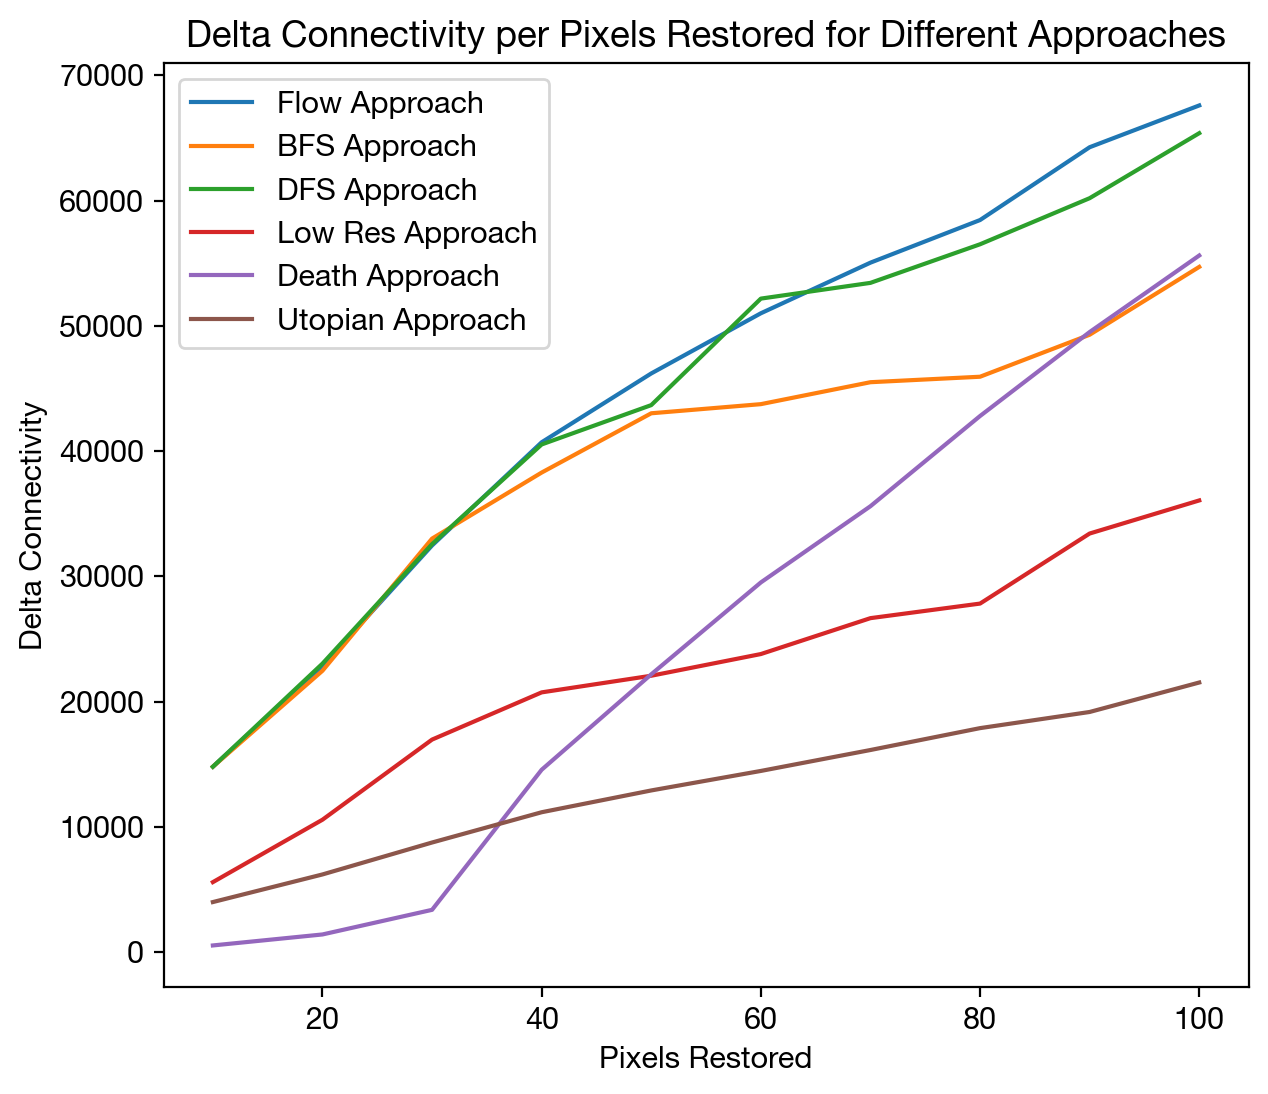

In [55]:
import matplotlib.pyplot as plt

# set mpl params
def setup_mpl():
    plt.rcParams['font.family'] = "Helvetica Neue"
    plt.rcParams['font.size'] = 11
    plt.rcParams['figure.figsize'] = (7,6)
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['lines.linewidth'] = 1.5
setup_mpl()

conn_px_results_list_2 = {}
conn_px_results_list_2["Flow Approach"] = conn_px_results_list['flow_approach']
conn_px_results_list_2["BFS Approach"] = conn_px_results_list['bfs_flow_approach']
conn_px_results_list_2["DFS Approach"] = conn_px_results_list['dfs_flow_approach']
conn_px_results_list_2["Low Res Approach"] = conn_px_results_list['low_res_flow_approach']
conn_px_results_list_2["Deficit Approach"] = conn_px_results_list['death_approach']
conn_px_results_list_2["Utopian Approach"] = conn_px_results_list['utopian_approach']

# Plotting
for approach, results in conn_px_results_list_2.items():
    plt.plot(n_range, results, label=approach)

# Add labels and title
plt.xlabel('Pixels Restored')
plt.ylabel('Delta Connectivity')
plt.title('Delta Connectivity per Pixels Restored for Different Approaches')
plt.legend()
plt.show()

# BFS Flow Restoration

In [6]:
# with method='flow/perm' corridor_hop=2

for corridor_hop in [1,2]:
    for num_corridors in [5,10,15]:
        bfsFlowOptimizer = bfsFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, PERMEABILITY_PATH, 50, hab_mat, unrestorable, num_corridors=num_corridors, corridor_hop=corridor_hop, metric='flow')

        bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
        permiability_restored = bfsFlowOptimizer.restore()
        bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
        print(f"Delta connectivity: {bfsFlowOptimizer.get_delta_connectivity()}")
        print(f"Permiability Restored: {permiability_restored}")
        print(f"Connectivity/permiability_restored: {round(bfsFlowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
        print(f"Connectivity/pixels restored: {round(bfsFlowOptimizer.get_delta_connectivity()/bfsFlowOptimizer.pixels, 2)}")

        TERRAIN_CHANGED_BFS = os.path.join(DATA_PATH, f"smol/changed_terrain_flow_bfs_hop{corridor_hop}_corridors{num_corridors}.tif")
        CONNECTIVITY_DIFF_BFS = os.path.join(DATA_PATH, f"smol/connectivity_diff_flow_bfs_hop{corridor_hop}_corridors{num_corridors}.tif")

        # paint changed terrain pixels
        bfsFlowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_BFS, value=1)
        # view diff of before and after
        bfsFlowOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF_BFS)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 20551
Permiability Restored: 4.990861313868612
Connectivity/permiability_restored: 4117.73
Connectivity/pixels restored: 411.02


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 19731
Permiability Restored: 4.990861313868612
Connectivity/permiability_restored: 3953.43
Connectivity/pixels restored: 394.62


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 22350
Permiability Restored: 4.990861313868612
Connectivity/permiability_restored: 4478.18
Connectivity/pixels restored: 447.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 41671
Permiability Restored: 4.990861313868612
Connectivity/permiability_restored: 8349.46
Connectivity/pixels restored: 833.42


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 43012
Permiability Restored: 4.990861313868612
Connectivity/permiability_restored: 8618.15
Connectivity/pixels restored: 860.24


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 43471
Permiability Restored: 4.990861313868612
Connectivity/permiability_restored: 8710.12
Connectivity/pixels restored: 869.42


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [7]:
# with method='flow/perm' corridor_hop=2
bfsFlowOptimizer = bfsFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, PERMEABILITY_PATH, 50, hab_mat, unrestorable, num_corridors=50, corridor_hop=2, metric='flow')

bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = bfsFlowOptimizer.restore()
bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {bfsFlowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Connectivity/permiability_restored: {round(bfsFlowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
print(f"Connectivity/pixels restored: {round(bfsFlowOptimizer.get_delta_connectivity()/bfsFlowOptimizer.pixels, 2)}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 46193
Permiability Restored: 4.990861313868612
Connectivity/permiability_restored: 9255.52
Connectivity/pixels restored: 923.86


In [6]:
# with method='flow/perm' corridor_hop=2
bfsFlowOptimizer = bfsFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, PERMEABILITY_PATH, 50, hab_mat, unrestorable, num_corridors=50, corridor_hop=2, metric='flow')

bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = bfsFlowOptimizer.restore()
bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {bfsFlowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Connectivity/permiability_restored: {round(bfsFlowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
print(f"Connectivity/pixels restored: {round(bfsFlowOptimizer.get_delta_connectivity()/bfsFlowOptimizer.pixels, 2)}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 46193
Permiability Restored: 4.990861313868612
Connectivity/permiability_restored: 9255.52
Connectivity/pixels restored: 923.86


In [3]:
# with method='flow/perm' corridor_hop=2

# with limited neighbors of neighbor
bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = bfsFlowOptimizer.restore()
bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {bfsFlowOptimizer.get_delta_connectivity()}")
print(f"Delta flow: {bfsFlowOptimizer.get_delta_flow()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Connectivity/permiability_restored: {round(bfsFlowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
print(f"Connectivity/pixels restored: {round(bfsFlowOptimizer.get_delta_connectivity()/bfsFlowOptimizer.pixels, 2)}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 35368
Delta flow: 18446744073709541272
Permiability Restored: 4.990861313868612


/Users/nvalett/Documents/Natalie/Species Dist Research/Code/ecoscape-earth/EcoLinker/EcoLinker/restorationOptimizer.py:52: RuntimeWarning: overflow encountered in ulong_scalars
  return post_restoration_flow - pre_restoration_flow


Connectivity/permiability_restored: 7086.55
Connectivity/pixels restored: 707.36


In [3]:
# with method='flow/perm' corridor_hop=2

bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = bfsFlowOptimizer.restore()
bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {bfsFlowOptimizer.get_delta_connectivity()}")
print(f"Delta flow: {bfsFlowOptimizer.get_delta_flow()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Connectivity/permiability_restored: {round(bfsFlowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
print(f"Connectivity/pixels restored: {round(bfsFlowOptimizer.get_delta_connectivity()/bfsFlowOptimizer.pixels, 2)}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 35368
Delta flow: 18446744073709541272
Permiability Restored: 4.990861313868612


/Users/nvalett/Documents/Natalie/Species Dist Research/Code/ecoscape-earth/EcoLinker/EcoLinker/restorationOptimizer.py:52: RuntimeWarning: overflow encountered in ulong_scalars
  return post_restoration_flow - pre_restoration_flow


Connectivity/permiability_restored: 7086.55
Connectivity/pixels restored: 707.36


In [6]:
# with corridor_hop=2
bfsFlowOptimizer = bfsFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, RESTORED_CONNECTIVITY_PATH, FLOW_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 50, hab_mat, unrestorable, corridor_hop=2)

bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = bfsFlowOptimizer.restore()
bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {bfsFlowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Connectivity/permiability_restored: {round(bfsFlowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
print(f"Connectivity/pixels restored: {round(bfsFlowOptimizer.get_delta_connectivity()/bfsFlowOptimizer.pixels, 2)}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 42331
Permiability Restored: 4.990861313868612
Connectivity/permiability_restored: 8481.7
Connectivity/pixels restored: 846.62


<Figure size 500x500 with 0 Axes>

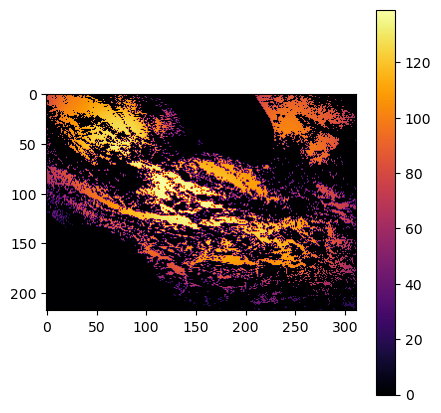

In [12]:
with GeoTiff.from_file(bfsFlowOptimizer.connectivity_fn) as conn:
    conn.draw_geotiff()

In [5]:
# with corridor_hop=1
bfsFlowOptimizer = bfsFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, RESTORED_CONNECTIVITY_PATH, FLOW_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 50, hab_mat, unrestorable, corridor_hop=1)

bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = bfsFlowOptimizer.restore()
print(bfsFlowOptimizer.changed_pixels)
bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {bfsFlowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Connectivity/permiability_restored: {round(bfsFlowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
print(f"Connectivity/pixels restored: {round(bfsFlowOptimizer.get_delta_connectivity()/bfsFlowOptimizer.pixels, 2)}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


{(277, 36): 78, (43, 72): 76, (41, 74): 75, (176, 109): 74, (188, 108): 73, (245, 102): 73, (155, 139): 73, (203, 115): 72, (278, 36): 72, (44, 75): 70, (277, 37): 33, (44, 73): 69, (42, 74): 65, (175, 109): 68, (187, 108): 44, (244, 102): 61, (202, 115): 69, (279, 35): 32, (43, 75): 70, (45, 73): 69, (42, 75): 60, (174, 109): 47, (187, 107): 28, (245, 103): 42, (201, 115): 66, (46, 73): 66, (41, 75): 32, (173, 109): 52, (186, 106): 45, (201, 114): 52, (46, 74): 55, (172, 109): 59, (185, 105): 19, (200, 114): 44, (171, 108): 45, (171, 109): 43, (171, 110): 40, (171, 111): 45, (268, 79): 70, (269, 79): 65, (270, 79): 61, (271, 79): 52, (272, 79): 50, (272, 80): 42, (134, 141): 70, (133, 141): 65, (271, 87): 70, (270, 87): 59, (269, 87): 61, (268, 87): 59}


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 22202
Permiability Restored: 4.990861313868612
Connectivity/permiability_restored: 4448.53
Connectivity/pixels restored: 444.04


In [5]:
TERRAIN_CHANGED_BFS = os.path.join(DATA_PATH, "smol/changed_terrain_flow_bfs.tif")
CONNECTIVITY_DIFF_BFS = os.path.join(DATA_PATH, "smol/connectivity_diff_flow_bfs.tif")

# paint changed terrain pixels
bfsFlowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_BFS, value=1)
# view diff of before and after
bfsFlowOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF_BFS)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


# Greedy Flow Restoration

In [21]:
# limited greedy Flow restoration
greedyFlowOptimizer = greedyFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, PERMEABILITY_PATH, 50, hab_mat, unrestorable, corridor_hop=2)

greedyFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = greedyFlowOptimizer.restore(verbose=True)
greedyFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {greedyFlowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Connectivity/permiability_restored: {round(greedyFlowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
print(f"Connectivity/pixels restored: {round(greedyFlowOptimizer.get_delta_connectivity()/greedyFlowOptimizer.pixels, 2)}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (277, 36) from 1402 with permiability 0.9 to 104 with permiability 1.0
Restoring pixel (43, 72) from 1402 with permiability 0.9 to 104 with permiability 1.0
Restoring pixel (41, 74) from 1402 with permiability 0.9 to 104 with permiability 1.0
Restoring pixel (176, 109) from 1402 with permiability 0.9 to 104 with permiability 1.0
Restoring pixel (188, 108) from 1402 with permiability 0.9 to 104 with permiability 1.0
Restoring pixel (245, 102) from 1402 with permiability 0.9 to 104 with permiability 1.0
Restoring pixel (155, 139) from 1403 with permiability 0.9091386861313868 to 104 with permiability 1.0
Restoring pixel (203, 115) from 1402 with permiability 0.9 to 104 with permiability 1.0
Restoring pixel (278, 36) from 1402 with permiability 0.9 to 104 with permiability 1.0
Restoring pixel (44, 75) from 1402 with permiability 0.9 to 104 with permiability 1.0
Restoring pixel (43, 75) from 1402 with permiability 0.9 to 104 with permiability 1.0
Restoring pixel (268, 79) f

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 43665
Permiability Restored: 4.990861313868612
Connectivity/permiability_restored: 8748.99
Connectivity/pixels restored: 873.3


In [8]:
# limited greedy Flow restoration
greedyFlowOptimizer = greedyFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, RESTORED_CONNECTIVITY_PATH, FLOW_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 50, hab_mat, unrestorable, corridor_hop=2)

greedyFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = greedyFlowOptimizer.restore(verbose=True)
greedyFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {greedyFlowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Connectivity/permiability_restored: {round(greedyFlowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
print(f"Connectivity/pixels restored: {round(greedyFlowOptimizer.get_delta_connectivity()/greedyFlowOptimizer.pixels, 2)}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (277, 36) from permiability 0.9 to 1.0
Restoring pixel (43, 72) from permiability 0.9 to 1.0
Restoring pixel (41, 74) from permiability 0.9 to 1.0
Restoring pixel (176, 109) from permiability 0.9 to 1.0
Restoring pixel (188, 108) from permiability 0.9 to 1.0
Restoring pixel (245, 102) from permiability 0.9 to 1.0
Restoring pixel (155, 139) from permiability 0.9091386861313868 to 1.0
Restoring pixel (203, 115) from permiability 0.9 to 1.0
Restoring pixel (278, 36) from permiability 0.9 to 1.0
Restoring pixel (44, 75) from permiability 0.9 to 1.0
Restoring pixel (43, 75) from permiability 0.9 to 1.0
Restoring pixel (268, 79) from permiability 0.9 to 1.0
Restoring pixel (134, 141) from permiability 0.9 to 1.0
Restoring pixel (271, 87) from permiability 0.9 to 1.0
Restoring pixel (11, 115) from permiability 0.9 to 1.0
Restoring pixel (119, 145) from permiability 0.9 to 1.0
Restoring pixel (202, 115) from permiability 0.9 to 1.0
Restoring pixel (204, 113) from permiability 0

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 43938
Permiability Restored: 5.190861313868611
Connectivity/permiability_restored: 8464.49
Connectivity/pixels restored: 878.76


In [22]:
TERRAIN_CHANGED_GREEDY = os.path.join(DATA_PATH, "smol/changed_terrain_flow_greedy_corridor_hop_2.tif")
CONNECTIVITY_DIFF_GREEDY = os.path.join(DATA_PATH, "smol/connectivity_diff_flow_greedy_corridor_hop_2.tif")

# paint changed terrain pixels
greedyFlowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_GREEDY, value=1)
# view diff of before and after
greedyFlowOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF_GREEDY)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


# Flow based restoration

In [24]:
# Flow restoration
flowOptimizer = flowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, PERMEABILITY_PATH, 50)

flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = flowOptimizer.restore()
flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {flowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Percent connectivity changed: {flowOptimizer.get_connectivity_percent_changed()}%")
print(f"Connectivity/permiability_restored: {round(flowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
print(f"Connectivity/pixels restored: {round(flowOptimizer.get_delta_connectivity()/flowOptimizer.pixels, 2)}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 46193
Permiability Restored: 4.990861313868612
Percent connectivity changed: 0.024354995692414113%
Connectivity/permiability_restored: 9255.52
Connectivity/pixels restored: 923.86


In [4]:
# Flow restoration
flowOptimizer = flowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 50) #hab_mat, unrestorable)

flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = flowOptimizer.restore()
flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {flowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Percent connectivity changed: {flowOptimizer.get_connectivity_percent_changed()}%")
print(f"Connectivity/permiability_restored: {round(flowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
print(f"Connectivity/pixels restored: {round(flowOptimizer.get_delta_connectivity()/flowOptimizer.pixels, 2)}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 46193
Permiability Restored: 4.990861313868612
Percent connectivity changed: 0.024354995692414113%
Connectivity/permiability_restored: 9255.52
Connectivity/pixels restored: 923.86


In [25]:
TERRAIN_CHANGED_GREEDY = os.path.join(DATA_PATH, "smol/changed_terrain_flow.tif")
CONNECTIVITY_DIFF_GREEDY = os.path.join(DATA_PATH, "smol/connectivity_diff_flow.tif")

# paint changed terrain pixels
flowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_GREEDY, value=1)
# view diff of before and after
flowOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF_GREEDY)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


# Low Res Flow

In [27]:
lowResFlowOptimizer = lowResFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, RESTORED_CONNECTIVITY_PATH, FLOW_PATH, RESTORED_FLOW_PATH, LOW_RES_FLOW_PATH, PERMEABILITY_PATH, 2, 2, 50, percent_impermiable=0.75)

# lowResFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = lowResFlowOptimizer.restore()
lowResFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {lowResFlowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Percent connectivity changed: {lowResFlowOptimizer.get_connectivity_percent_changed()}%")
print(f"Connectivity/permiability_restored: {lowResFlowOptimizer.get_delta_connectivity()/permiability_restored}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 22059
Permiability Restored: 5.190861313868611
Percent connectivity changed: 0.01163048189074022%
Connectivity/permiability_restored: 4249.583771591851


In [28]:
TERRAIN_CHANGED_GREEDY = os.path.join(DATA_PATH, "smol/changed_terrain_low_res_flow.tif")
CONNECTIVITY_DIFF_GREEDY = os.path.join(DATA_PATH, "smol/connectivity_diff_low_res_flow.tif")

# paint changed terrain pixels
lowResFlowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_GREEDY, value=1)
# view diff of before and after
lowResFlowOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF_GREEDY)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [4]:
lowResFlowOptimizer = lowResFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, RESTORED_CONNECTIVITY_PATH, FLOW_PATH, RESTORED_FLOW_PATH, DEATH_PATH, LOW_RES_FLOW_PATH, PERMEABILITY_PATH, 2, 2, 50, percent_impermiable=0.75)

lowResFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = lowResFlowOptimizer.restore()
lowResFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {lowResFlowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Percent connectivity changed: {lowResFlowOptimizer.get_connectivity_percent_changed()}%")
print(f"Connectivity/permiability_restored: {lowResFlowOptimizer.get_delta_connectivity()/permiability_restored}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 22059
Permiability Restored: 5.190861313868611
Percent connectivity changed: 0.01163048189074022%
Connectivity/permiability_restored: 4249.583771591851


In [6]:
TERRAIN_CHANGED_UTOPIAN = os.path.join(DATA_PATH, "smol/changed_terrain_flow_low_res.tif")
CONNECTIVITY_DIFF_UTOPIAN = os.path.join(DATA_PATH, "smol/connectivity_diff_flow_low_res.tif")

# paint changed terrain pixels
lowResFlowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_UTOPIAN, value=1)
# view diff of before and after
lowResFlowOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF_UTOPIAN)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [67]:
TERRAIN_CHANGED_UTOPIAN = os.path.join(DATA_PATH, "smol/changed_terrain_flow_low_res.tif")
CONNECTIVITY_DIFF_UTOPIAN = os.path.join(DATA_PATH, "smol/connectivity_diff_flow_low_res.tif")

def get_connectivity_difference_tif(flowOptimizer, connectivity_diff_fn):
    # get origional connectivity
    with GeoTiff.from_file(flowOptimizer.connectivity_fn) as connectivity_tif:
        connectivity_tile = connectivity_tif.get_all_as_tile()
        # create connectivity diff tif from clone of connectivity_tif
        connectivity_tif.clone_shape(connectivity_diff_fn, dtype='int16')

    # get restored connectivity
    with GeoTiff.from_file(flowOptimizer.restored_connectivity_fn) as restored_connectivity_tif:
        restored_connectivity_tile = restored_connectivity_tif.get_all_as_tile()

    # get the difference of the two in a tile
    diff = Tile(connectivity_tile.w, connectivity_tile.h, connectivity_tile.b, connectivity_tile.c, connectivity_tile.x, connectivity_tile.y, (restored_connectivity_tile.m.astype('int16') - connectivity_tile.m.astype('int16')))
    # write the tile to connectivity diff tif
    with GeoTiff.from_file(connectivity_diff_fn) as connectivity_diff:
        connectivity_diff.set_tile(diff)


# paint changed terrain pixels
lowResFlowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_UTOPIAN, flowOptimizer.changed_pixels, value=1)
# view diff of before and after
get_connectivity_difference_tif(lowResFlowOptimizer, CONNECTIVITY_DIFF_UTOPIAN)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [74]:
DATA_PATH="/Users/nvalett/Documents/Natalie/Species Dist Research/Thesis/EcoLinker/tests/assets"
HABITAT_PATH = os.path.join(DATA_PATH, "smol_fragmented/habitat.tif")
TERRAIN_PATH = os.path.join(DATA_PATH, "smol_fragmented/terrain.tif")
RESTORED_TERRAIN_PATH = os.path.join(DATA_PATH, "smol_fragmented/restored_ter_smol.tif")
PERMEABILITY_PATH = os.path.join(DATA_PATH, "paper_repro/transmission_refined_1.csv")

CONNECTIVITY_PATH = os.path.join(DATA_PATH, "smol_fragmented/repop.tif")
RESTORED_CONNECTIVITY_PATH = os.path.join(DATA_PATH, "smol_fragmented/repop_after_restoration.tif")
FLOW_PATH = os.path.join(DATA_PATH, "smol_fragmented/grad.tif")
RESTORED_FLOW_PATH = os.path.join(DATA_PATH, "smol_fragmented/grad_after_restoration.tif")
LOW_RES_FLOW_PATH = os.path.join(DATA_PATH, "smol_fragmented/flow_low_res.tif")

unrestorable = [104,500, 501, 502, 503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,900, 901, 902, 903, 904, 905, 906,907,980,981,982,983,984,985,986,909,910,1000,1001,1002,1003,1004,1100,1101,1111,1112,1102,1103,1104,1105,1106,1200,1201,1202,1203,1204,1205,1206,1207,1300,1301,1302,1303,1304,1305,    1402]

with GeoTiff.from_file(HABITAT_PATH) as hab:
    hab_mat = hab.get_all_as_tile().m.squeeze(0)

flowOptimizer = flowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 50, hab_mat, unrestorable)
lowResFlowOptimizer = lowResFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, RESTORED_CONNECTIVITY_PATH, FLOW_PATH, RESTORED_FLOW_PATH, DEATH_PATH, LOW_RES_FLOW_PATH, PERMEABILITY_PATH, 2, 2, 50)

In [75]:
flowOptimizer = flowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 50) #hab_mat, unrestorable)

results = {}
for gap_crossing in [2,3,4,5]:
    for num_gaps in [20,40,60,80]:
        flowOptimizer.run_connectivity(gap_crossing=gap_crossing, num_gaps=num_gaps)
        permiability_restored = flowOptimizer.restore()
        flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=False)
        flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
        print(f"Delta connectivity: {flowOptimizer.get_delta_connectivity()}")
        print(f"Permiability Restored: {permiability_restored}")
        print(f"Percent connectivity changed: {flowOptimizer.get_connectivity_percent_changed()}%")
        print(f"Connectivity/permiability_restored: {flowOptimizer.get_delta_connectivity()/permiability_restored}")
        results[(gap_crossing, num_gaps)] = flowOptimizer.get_delta_connectivity()/permiability_restored

        TERRAIN_CHANGED_UTOPIAN = os.path.join(DATA_PATH, f"smol_fragmented/changed_terrain_flow_low_res_{gap_crossing}_{num_gaps}.tif")
        CONNECTIVITY_DIFF_UTOPIAN = os.path.join(DATA_PATH, f"smol_fragmented/connectivity_diff_flow_low_res_{gap_crossing}_{num_gaps}.tif")

        # paint changed terrain pixels
        flowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_UTOPIAN, value=1)
        # view diff of before and after
        flowOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF_UTOPIAN)
print(results)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 32602
Permiability Restored: 4.936029197080292
Percent connectivity changed: 0.0009304348014693804%
Connectivity/permiability_restored: 6604.904205040843


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 32602
Permiability Restored: 4.936029197080292
Percent connectivity changed: 0.0009304348014693804%
Connectivity/permiability_restored: 6604.904205040843


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 32602
Permiability Restored: 4.936029197080292
Percent connectivity changed: 0.0009304348014693804%
Connectivity/permiability_restored: 6604.904205040843


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 32602
Permiability Restored: 4.936029197080292
Percent connectivity changed: 0.0009304348014693804%
Connectivity/permiability_restored: 6604.904205040843


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 3806
Permiability Restored: 4.9634452554744515
Percent connectivity changed: 0.00010862017221006262%
Connectivity/permiability_restored: 766.8060800715305


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 3806
Permiability Restored: 4.9634452554744515
Percent connectivity changed: 0.00010862017221006262%
Connectivity/permiability_restored: 766.8060800715305


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 3806
Permiability Restored: 4.9634452554744515
Percent connectivity changed: 0.00010862017221006262%
Connectivity/permiability_restored: 766.8060800715305


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 3806
Permiability Restored: 4.9634452554744515
Percent connectivity changed: 0.00010862017221006262%
Connectivity/permiability_restored: 766.8060800715305


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 770
Permiability Restored: 4.945167883211678
Percent connectivity changed: 2.19751793488566e-05%
Connectivity/permiability_restored: 155.70755496776331


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 770
Permiability Restored: 4.945167883211678
Percent connectivity changed: 2.19751793488566e-05%
Connectivity/permiability_restored: 155.70755496776331


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 770
Permiability Restored: 4.945167883211678
Percent connectivity changed: 2.19751793488566e-05%
Connectivity/permiability_restored: 155.70755496776331


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 770
Permiability Restored: 4.945167883211678
Percent connectivity changed: 2.19751793488566e-05%
Connectivity/permiability_restored: 155.70755496776331


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


KeyboardInterrupt: 

In [22]:
# Flow restoration
flowOptimizer = flowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 50) #hab_mat, unrestorable)

# flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = flowOptimizer.restore()
flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {flowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Percent connectivity changed: {flowOptimizer.get_connectivity_percent_changed()}%")
print(f"Connectivity/permiability_restored: {round(flowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 32602
Permiability Restored: 4.936029197080292
Percent connectivity changed: 0.0009304348014693804%
Connectivity/permiability_restored: 6604.9


In [ ]:
# Flow restoration
flowOptimizer = flowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 50) #hab_mat, unrestorable)

flowOptimizer.run_connectivity(gap_crossing=3, num_gaps=50)
permiability_restored = flowOptimizer.restore()
flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {flowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Percent connectivity changed: {flowOptimizer.get_connectivity_percent_changed()}%")
print(f"Connectivity/permiability_restored: {round(flowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")

In [25]:
print(len(flowOptimizer.changed_pixels))
print(flowOptimizer.changed_pixels)

50
{(360, 460): 80, (598, 75): 79, (574, 138): 76, (568, 658): 76, (570, 656): 75, (564, 1067): 75, (584, 1090): 74, (575, 1092): 71, (574, 1090): 71, (621, 111): 70, (539, 159): 70, (581, 138): 70, (582, 660): 70, (492, 735): 69, (346, 425): 69, (493, 732): 69, (579, 69): 69, (586, 75): 69, (452, 413): 69, (558, 656): 68, (581, 815): 68, (583, 153): 68, (545, 101): 68, (620, 109): 68, (570, 1069): 68, (592, 1074): 68, (590, 1075): 68, (591, 1075): 68, (583, 1090): 68, (471, 287): 67, (582, 153): 67, (606, 665): 67, (503, 753): 67, (452, 414): 67, (472, 284): 67, (663, 462): 67, (614, 114): 67, (462, 1127): 66, (590, 1077): 66, (566, 773): 66, (598, 1071): 66, (562, 772): 66, (447, 1024): 66, (517, 654): 66, (320, 423): 66, (523, 855): 66, (556, 130): 66, (635, 893): 65, (613, 114): 65, (677, 622): 65}


In [23]:
TERRAIN_CHANGED_UTOPIAN = os.path.join(DATA_PATH, "smol_fragmented/changed_terrain_flow.tif")
CONNECTIVITY_DIFF_UTOPIAN = os.path.join(DATA_PATH, "smol_fragmented/connectivity_diff_flow.tif")

# paint changed terrain pixels
flowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_UTOPIAN, value=1)
# view diff of before and after
flowOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF_UTOPIAN)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [26]:
# low res with factor of 2
lowResFlowOptimizer = lowResFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, RESTORED_CONNECTIVITY_PATH, FLOW_PATH, RESTORED_FLOW_PATH, DEATH_PATH, LOW_RES_FLOW_PATH, PERMEABILITY_PATH, 2, 2, 50, percent_impermiable=0.75)

lowResFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = lowResFlowOptimizer.restore()
lowResFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {lowResFlowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Percent connectivity changed: {lowResFlowOptimizer.get_connectivity_percent_changed()}%")
print(f"Connectivity/permiability_restored: {lowResFlowOptimizer.get_delta_connectivity()/permiability_restored}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


[(740, 668), (740, 669), (741, 668), (741, 669), (592, 692), (592, 693), (593, 692), (593, 693), (286, 834), (286, 835), (287, 834), (108, 1130), (108, 1131), (109, 1130), (109, 1131), (64, 1122), (65, 1122), (65, 1123), (72, 1114), (72, 1115), (73, 1114), (73, 1115), (92, 1090), (92, 1091), (93, 1090), (93, 1091), (506, 968), (506, 969), (507, 968), (507, 969), (590, 1075), (591, 1074), (591, 1075), (610, 1140), (610, 1141), (611, 1140), (611, 1141), (222, 818), (222, 819), (223, 818), (223, 819), (490, 746), (490, 747), (491, 746), (491, 747), (570, 660), (570, 661), (571, 660), (571, 661), (408, 470), (408, 471), (409, 470)]


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 11605
Permiability Restored: 5.512934306569342
Percent connectivity changed: 0.0003311973459006245%
Connectivity/permiability_restored: 2105.049571545086


In [27]:
TERRAIN_CHANGED_UTOPIAN = os.path.join(DATA_PATH, "smol_fragmented/changed_terrain_flow_low_res_2_2.tif")
CONNECTIVITY_DIFF_UTOPIAN = os.path.join(DATA_PATH, "smol_fragmented/connectivity_diff_flow_low_res_2_2.tif")

# paint changed terrain pixels
lowResFlowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_UTOPIAN, value=1)
# view diff of before and after
lowResFlowOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF_UTOPIAN)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [29]:
# low res with factor of 4
lowResFlowOptimizer = lowResFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, RESTORED_CONNECTIVITY_PATH, FLOW_PATH, RESTORED_FLOW_PATH, DEATH_PATH, LOW_RES_FLOW_PATH, PERMEABILITY_PATH, 4, 4, 50, percent_impermiable=0.75)

# lowResFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = lowResFlowOptimizer.restore()
lowResFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {lowResFlowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Percent connectivity changed: {lowResFlowOptimizer.get_connectivity_percent_changed()}%")
print(f"Connectivity/permiability_restored: {lowResFlowOptimizer.get_delta_connectivity()/permiability_restored}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


[(220, 816), (220, 819), (221, 818), (221, 819), (222, 816), (222, 817), (222, 818), (222, 819), (223, 816), (223, 817), (223, 818), (223, 819), (492, 732), (492, 733), (492, 734), (492, 735), (493, 732), (493, 733), (493, 734), (493, 735), (494, 732), (494, 733), (494, 735), (495, 732), (495, 733), (495, 735), (400, 369), (400, 370), (400, 371), (401, 368), (401, 369), (401, 370), (402, 368), (402, 369), (402, 370), (403, 368), (403, 369), (403, 370), (64, 1120), (64, 1121), (64, 1122), (65, 1121), (65, 1122), (65, 1123), (66, 1120), (66, 1121), (66, 1122), (66, 1123), (67, 1122), (67, 1123)]


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 4999
Permiability Restored: 7.3780145985401475
Percent connectivity changed: 0.00014266743060381058%
Connectivity/permiability_restored: 677.5535522780245


In [32]:
# low res with factor of 4
lowResFlowOptimizer = lowResFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, RESTORED_CONNECTIVITY_PATH, FLOW_PATH, RESTORED_FLOW_PATH, DEATH_PATH, LOW_RES_FLOW_PATH, PERMEABILITY_PATH, 4, 4, 50, percent_impermiable=0.25)

# lowResFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = lowResFlowOptimizer.restore()
lowResFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {lowResFlowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Percent connectivity changed: {lowResFlowOptimizer.get_connectivity_percent_changed()}%")
print(f"Connectivity/permiability_restored: {lowResFlowOptimizer.get_delta_connectivity()/permiability_restored}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


[(601, 372), (601, 373), (602, 372), (602, 373), (412, 479), (414, 477), (415, 477), (415, 479), (254, 900), (254, 901), (255, 900), (255, 901), (212, 846), (212, 847), (213, 845), (213, 847), (202, 862), (202, 863), (203, 862), (203, 863), (132, 1064), (132, 1067), (133, 1067), (135, 1066), (174, 933), (174, 934), (175, 932), (175, 933), (256, 915), (257, 915), (258, 915), (259, 914), (588, 1075), (590, 1075), (591, 1073), (591, 1074), (591, 1075), (614, 378), (614, 379), (615, 378), (615, 379), (164, 992), (164, 993), (166, 993), (166, 995), (161, 1149), (162, 1148), (162, 1149), (162, 1150), (597, 374), (597, 375), (598, 372), (599, 372)]


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


KeyboardInterrupt: 

In [30]:
TERRAIN_CHANGED_UTOPIAN = os.path.join(DATA_PATH, "smol_fragmented/changed_terrain_flow_low_res_4_4.tif")
CONNECTIVITY_DIFF_UTOPIAN = os.path.join(DATA_PATH, "smol_fragmented/connectivity_diff_flow_low_res_4_4.tif")

# paint changed terrain pixels
lowResFlowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_UTOPIAN, value=1)
# view diff of before and after
lowResFlowOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF_UTOPIAN)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [7]:
def get_greedy_flow_pixels(optimizer, flow, n=None):
    if (n == None):
        n = optimizer.pixels
    flow = flow.squeeze(0)
    total_px = flow.shape[0] * flow.shape[1]
    flat_indices = np.argpartition(flow.ravel(), -total_px)[-total_px:]
    row_indices, col_indices = np.unravel_index(flat_indices, flow.shape)

    min_elements = flow[row_indices, col_indices]
    min_elements_order = np.argsort(min_elements)
    row_indices, col_indices = row_indices[min_elements_order], col_indices[min_elements_order]

    highest_flow = {}
    with GeoTiff.from_file(optimizer.terrain_fn) as terr:
        raw_terrain = terr.get_all_as_tile().m.squeeze(0)
    with GeoTiff.from_file(optimizer.habitat_fn) as hab:
        raw_hab = hab.get_all_as_tile().m.squeeze(0)

    i = total_px
    while (len(highest_flow.items()) < n and i > 0):
        stack = [(col_indices[i-1], row_indices[i-1])]
        while len(stack) > 0:
            col, row = stack.pop()
            terrain = raw_terrain[row][col]
            permiability = optimizer.permeability_dict[terrain]
            if permiability < 1 and raw_hab[row][col] != 1:
                highest_flow[(col, row)] = flow[row][col]
                # find highest grad of neighbors and push to stack
                max_neighbor = ()
                max_neighbor_flow = 0
                for neighbor_col, neighbor_row in [(col - 1, row), (col + 1, row), (col, row - 1), (col, row + 1), (col - 1, row - 1), (col + 1, row + 1), (col - 1, row + 1), (col + 1, row - 1)]:
                    if neighbor_col >= 0 and neighbor_col < flow.shape[1] and neighbor_row >= 0 and neighbor_row < flow.shape[0]:
                        neighbor_flow = flow[neighbor_row][neighbor_col]
                        if neighbor_flow > max_neighbor_flow and (neighbor_col, neighbor_row) not in highest_flow:
                            max_neighbor = (neighbor_col, neighbor_row)
                            max_neighbor_flow = neighbor_flow
                if max_neighbor_flow > 0:
                    stack.append(max_neighbor)
            else:
                break
        i -= 1
    return highest_flow

with GeoTiff.from_file(flowOptimizer.flow_fn) as flow_tif:
    flow = flow_tif.get_all_as_tile().m

highest_flow = get_greedy_flow_pixels(flowOptimizer, flow)
print(highest_flow)

{(307, 52): 0, (3, 53): 0, (2, 53): 0, (1, 53): 0, (8, 199): 0, (311, 52): 0, (310, 52): 0, (309, 52): 0, (308, 52): 0, (309, 158): 0, (4, 53): 0, (305, 52): 0, (304, 52): 0, (303, 52): 0, (302, 52): 0, (301, 52): 0, (300, 52): 0, (299, 52): 0, (298, 52): 0, (297, 52): 0, (306, 52): 0, (6, 53): 0, (5, 53): 0, (18, 53): 0, (3, 199): 0, (4, 199): 0, (5, 199): 0, (6, 199): 0, (7, 199): 0, (22, 53): 0, (21, 53): 0, (20, 53): 0, (19, 53): 0, (17, 53): 0, (7, 53): 0, (16, 53): 0, (15, 53): 0, (14, 53): 0, (13, 53): 0, (12, 53): 0, (11, 53): 0, (10, 53): 0, (9, 53): 0, (8, 53): 0, (296, 52): 0, (295, 52): 0, (29, 53): 0, (294, 52): 0, (30, 199): 0, (31, 199): 0, (32, 199): 0, (33, 199): 0, (34, 199): 0, (264, 52): 0, (263, 52): 0, (35, 199): 0, (36, 199): 0, (260, 52): 0, (259, 52): 0, (258, 52): 0, (257, 52): 0, (256, 52): 0, (255, 52): 0, (254, 52): 0, (253, 52): 0, (252, 52): 0, (251, 52): 0, (250, 52): 0, (249, 52): 0, (29, 199): 0, (28, 199): 0, (27, 199): 0, (15, 199): 0, (293, 52): 0, 

In [ ]:
def get_greedy_flow_pixels(self, flow, n=None):
    if (n == None):
        n = self.pixels
    flow = flow.squeeze(0)
    total_px = flow.shape[0] * flow.shape[1]
    flat_indices = np.argpartition(flow.ravel(), -total_px)[-total_px:]
    row_indices, col_indices = np.unravel_index(flat_indices, flow.shape)

    min_elements = flow[row_indices, col_indices]
    min_elements_order = np.argsort(min_elements)
    row_indices, col_indices = row_indices[min_elements_order], col_indices[min_elements_order]

    highest_flow = {}
    with GeoTiff.from_file(self.terrain_fn) as terr:
        raw_terrain = terr.get_all_as_tile().m.squeeze(0)
    with GeoTiff.from_file(self.habitat_fn) as hab:
        raw_hab = hab.get_all_as_tile().m.squeeze(0)

    i = total_px
    while (len(highest_flow.items()) < n and i > 0):
        stack = [(col_indices[i-1], row_indices[i-1])]
        while len(stack) > 0:
            col, row = stack.pop()
            terrain = raw_terrain[row][col]
            permiability = self.permeability_dict[terrain]
            if permiability < 1 and raw_hab[row][col] != 1:
                highest_flow[(col, row)] = flow[row][col]
                # find highest grad of neighbors and push to stack
                max_neighbor = ()
                max_neighbor_flow = 0
                for neighbor_col, neighbor_row in [(col - 1, row), (col + 1, row), (col, row - 1), (col, row + 1), (col - 1, row - 1), (col + 1, row + 1), (col - 1, row + 1), (col + 1, row - 1)]:
                    neighbor_flow = flow[neighbor_row][neighbor_col]
                    if neighbor_flow > max_neighbor_flow and (neighbor_col, neighbor_row) not in highest_flow:
                        max_neighbor = (neighbor_col, neighbor_row)
                        max_neighbor_flow = neighbor_flow
                stack.append(max_neighbor)
            else:
                break
        i -= 1
    return highest_flow

In [28]:
TERRAIN_CHANGED_GREEDY = os.path.join(DATA_PATH, "smol/changed_terrain_flow_greedy.tif")

flowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_GREEDY, highest_flow, value=1)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

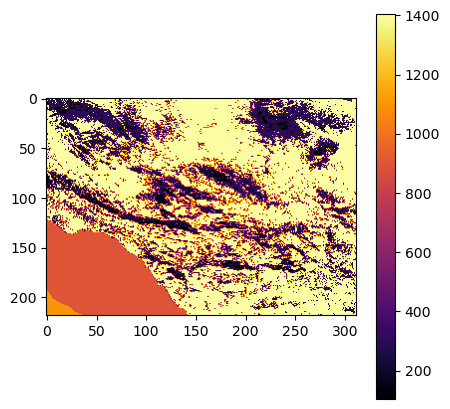

<Figure size 500x500 with 0 Axes>

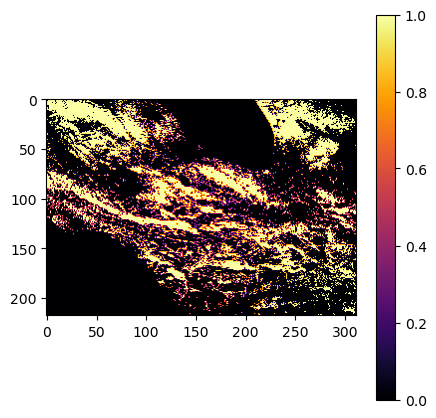

{(277, 36): 78, (43, 72): 76, (41, 74): 75, (176, 109): 74, (188, 108): 73, (245, 102): 73, (155, 139): 73, (203, 115): 72, (278, 36): 72, (44, 75): 70, (43, 75): 70, (268, 79): 70, (134, 141): 70, (271, 87): 70, (11, 115): 69, (119, 145): 69, (202, 115): 69, (103, 117): 69, (45, 73): 69, (44, 73): 69, (41, 85): 69, (203, 109): 69, (109, 141): 68, (199, 159): 68, (267, 75): 68, (27, 70): 68, (175, 109): 68, (202, 109): 68, (204, 109): 68, (109, 142): 67, (163, 105): 67, (245, 122): 67, (246, 122): 67, (89, 132): 67, (29, 68): 67, (216, 114): 67, (33, 64): 67, (31, 66): 67, (152, 138): 66, (134, 62): 66, (118, 145): 66, (277, 118): 66, (201, 115): 66, (220, 198): 66, (46, 73): 66, (128, 56): 66, (269, 83): 66, (120, 49): 65, (136, 64): 65, (133, 141): 65}


In [45]:
# starting from working version
flowOptimizer = flowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 50, hab_mat, unrestorable)

def get_greedy_flow_pixels(optimizer, flow, n=None):
    if (n == None):
        n = optimizer.pixels
    flow = flow.squeeze(0)
    total_px = flow.shape[0] * flow.shape[1]
    flat_indices = np.argpartition(flow.ravel(), -total_px)[-total_px:]
    row_indices, col_indices = np.unravel_index(flat_indices, flow.shape)

    min_elements = flow[row_indices, col_indices]
    min_elements_order = np.argsort(min_elements)
    row_indices, col_indices = row_indices[min_elements_order], col_indices[min_elements_order]

    highest_flow = {}
    with GeoTiff.from_file(optimizer.terrain_fn) as terr:
        raw_terrain = terr.get_all_as_tile().m.squeeze(0)
        terr.draw_geotiff()
    with GeoTiff.from_file(optimizer.habitat_fn) as hab:
        raw_hab = hab.get_all_as_tile().m.squeeze(0)
        hab.draw_geotiff()

    i = total_px
    while (len(highest_flow.items()) < n and i > 0):
        stack = [(col_indices[i-1], row_indices[i-1])]
        col, row = col_indices[i-1], row_indices[i-1]
        # while len(stack) > 0:
        #     print(stack)
        #     col, row = stack.pop()
        terrain = raw_terrain[row][col]
        permiability = optimizer.permeability_dict[terrain]
        if permiability < 1: #and raw_hab[row][col] != 1:
            highest_flow[(col, row)] = flow[row][col]
        #         # find highest grad of neighbors and push to stack
        #         max_neighbor = ()
        #         max_neighbor_flow = 0
        #         for neighbor_col, neighbor_row in [(col - 1, row), (col + 1, row), (col, row - 1), (col, row + 1), (col - 1, row - 1), (col + 1, row + 1), (col - 1, row + 1), (col + 1, row - 1)]:
        #             if neighbor_col >= 0 and neighbor_col < flow.shape[1] and neighbor_row >= 0 and neighbor_row < flow.shape[0]:
        #                 neighbor_flow = flow[neighbor_row][neighbor_col]
        #                 if neighbor_flow > max_neighbor_flow and (neighbor_col, neighbor_row) not in highest_flow:
        #                     print(neighbor_flow)
                            
        #                     max_neighbor = (neighbor_col, neighbor_row)
        #                     max_neighbor_flow = neighbor_flow
        #         if max_neighbor_flow > 0:
        #             stack.append(max_neighbor)
        #     else:
        #         break
        i -= 1
    return highest_flow

with GeoTiff.from_file(flowOptimizer.habitat_fn) as hab:
    hab_m = hab.get_all_as_tile().m
with GeoTiff.from_file(flowOptimizer.flow_fn) as flow_tif:
    flow = flow_tif.get_all_as_tile().m

# flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
highest_flow = get_greedy_flow_pixels(flowOptimizer, flow)
print(highest_flow)

In [ ]:
# starting from working version
flowOptimizer = flowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 100, hab_mat, unrestorable)

def get_greedy_flow_pixels(optimizer, flow, n=None, number_corridors=None):
    if (n == None):
        n = optimizer.pixels
    flow = flow.squeeze(0)
    total_px = flow.shape[0] * flow.shape[1]
    flat_indices = np.argpartition(flow.ravel(), -total_px)[-total_px:]
    row_indices, col_indices = np.unravel_index(flat_indices, flow.shape)

    min_elements = flow[row_indices, col_indices]
    min_elements_order = np.argsort(min_elements)
    row_indices, col_indices = row_indices[min_elements_order], col_indices[min_elements_order]

    highest_flow = {}
    with GeoTiff.from_file(optimizer.terrain_fn) as terr:
        raw_terrain = terr.get_all_as_tile().m.squeeze(0)
        terr.draw_geotiff()
    with GeoTiff.from_file(optimizer.habitat_fn) as hab:
        raw_hab = hab.get_all_as_tile().m.squeeze(0)
        hab.draw_geotiff()

    i = total_px
    stack = []
    seen = []
    while len(stack) < number_corridors:
        terrain = raw_terrain[row_indices[i-1]][col_indices[i-1]]
        permiability = optimizer.permeability_dict[terrain]
        if permiability < 1 and raw_hab[row_indices[i-1]][col_indices[i-1]] != 1:
            stack.append((col_indices[i-1], row_indices[i-1]))
        i -= 1
    while (len(highest_flow.items()) < n and len(stack) > 0):
        while len(stack) > 0:
            print(stack)
            col, row = stack.pop()
            terrain = raw_terrain[row][col]
            permiability = optimizer.permeability_dict[terrain]
            if permiability < 1 and raw_hab[row][col] != 1: # on start-up, has the propensity to not register raw_hab[row][col] != 1 as true
                highest_flow[(col, row)] = flow[row][col]
                # find highest grad of neighbors and push to stack
                max_neighbor = ()
                max_neighbor_flow = 0
                for neighbor_col, neighbor_row in [(col - 1, row), (col + 1, row), (col, row - 1), (col, row + 1), (col - 1, row - 1), (col + 1, row + 1), (col - 1, row + 1), (col + 1, row - 1)]:
                    if neighbor_col >= 0 and neighbor_col < flow.shape[1] and neighbor_row >= 0 and neighbor_row < flow.shape[0]:
                        neighbor_flow = flow[neighbor_row][neighbor_col]
                        if neighbor_flow > max_neighbor_flow and (neighbor_col, neighbor_row) not in highest_flow:
                            max_neighbor = (neighbor_col, neighbor_row)
                            max_neighbor_flow = neighbor_flow
                if max_neighbor_flow > 0:
                    stack.append(max_neighbor)
            else:
                break
        i -= 1
    return highest_flow

with GeoTiff.from_file(flowOptimizer.habitat_fn) as hab:
    hab_m = hab.get_all_as_tile().m
with GeoTiff.from_file(flowOptimizer.flow_fn) as flow_tif:
    flow = flow_tif.get_all_as_tile().m

# flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
highest_flow = get_greedy_flow_pixels(flowOptimizer, flow)
print(highest_flow)

In [14]:
flowOptimizer = flowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 50, hab_mat, unrestorable)

def get_bfs_flow_pixels(optimizer, flow, n=None, number_corridors=None):
    if (n == None):
        n = optimizer.pixels
    if (number_corridors == None):
        number_corridors = n / 5
    flow = flow.squeeze(0)
    total_px = flow.shape[0] * flow.shape[1]
    flat_indices = np.argpartition(flow.ravel(), -total_px)[-total_px:]
    row_indices, col_indices = np.unravel_index(flat_indices, flow.shape)

    min_elements = flow[row_indices, col_indices]
    min_elements_order = np.argsort(min_elements)
    row_indices, col_indices = row_indices[min_elements_order], col_indices[min_elements_order]

    highest_flow = {}
    with GeoTiff.from_file(optimizer.terrain_fn) as terr:
        raw_terrain = terr.get_all_as_tile().m.squeeze(0)
    with GeoTiff.from_file(optimizer.habitat_fn) as hab:
        raw_hab = hab.get_all_as_tile().m.squeeze(0)

    i = total_px
    stack = []
    seen = []
    while len(stack) < number_corridors:
        print(flow[row_indices[i-1]][col_indices[i-1]])
        terrain = raw_terrain[row_indices[i-1]][col_indices[i-1]]
        permiability = optimizer.permeability_dict[terrain]
        if permiability < 1 and raw_hab[row_indices[i-1]][col_indices[i-1]] != 1:
            stack.append((col_indices[i-1], row_indices[i-1]))
        i -= 1
    while (len(highest_flow.items()) < n and len(stack) > 0):
        col, row = stack.pop(0)
        seen.append((col, row))
        terrain = raw_terrain[row][col]
        permiability = optimizer.permeability_dict[terrain]
        if permiability < 1 and raw_hab[row][col] != 1:
            highest_flow[(col, row)] = flow[row][col]
            # find highest grad of neighbors and push to stack
            max_neighbor = ()
            max_neighbor_flow = 0
            for neighbor_col, neighbor_row in [(col - 1, row), (col + 1, row), (col, row - 1), (col, row + 1), (col - 1, row - 1), (col + 1, row + 1), (col - 1, row + 1), (col + 1, row - 1)]:
                if neighbor_col >= 0 and neighbor_col < flow.shape[1] and neighbor_row >= 0 and neighbor_row < flow.shape[0]:
                    neighbor_flow = flow[neighbor_row][neighbor_col]
                    if neighbor_flow > max_neighbor_flow and (neighbor_col, neighbor_row) not in highest_flow and (neighbor_col, neighbor_row) not in seen and (neighbor_col, neighbor_row) not in stack and optimizer.permeability_dict[raw_terrain[row][col]] < 1 and raw_hab[row][col] != 1: 
                        # limited neighbors in highest_flow
                        neighbors_of_neighbors_in_highest_flow = [x for x in [(neighbor_col - 1, neighbor_row), (neighbor_col + 1, neighbor_row), (neighbor_col, neighbor_row - 1), (neighbor_col, neighbor_row + 1), (neighbor_col - 1, neighbor_row - 1), (neighbor_col + 1, neighbor_row + 1), (neighbor_col - 1, neighbor_row + 1), (neighbor_col + 1, neighbor_row - 1)] if x in highest_flow]
                        if len(neighbors_of_neighbors_in_highest_flow) > 3:
                            break
                        max_neighbor = (neighbor_col, neighbor_row)
                        max_neighbor_flow = neighbor_flow
            if max_neighbor_flow > 0:
                stack.append(max_neighbor)
            else:
                stack.append((col_indices[i-1], row_indices[i-1]))
                i -= 1
        # else:
        #     stack.append((col_indices[i-1], row_indices[i-1]))
        #     i -= 1
    return highest_flow

with GeoTiff.from_file(flowOptimizer.flow_fn) as flow_tif:
    flow = flow_tif.get_all_as_tile().m

# flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
highest_flow = get_bfs_flow_pixels(flowOptimizer, flow)
print(highest_flow)

140
140
140
140
140
140
140
140
140
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138


In [42]:
print(len(highest_flow))

100


In [11]:
TERRAIN_CHANGED_GREEDY = os.path.join(DATA_PATH, "smol/changed_terrain_flow_bfs.tif")

flowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_GREEDY, highest_flow, value=1)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
